In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import precision_recall_curve
import catboost as cb
import gc
from sklearn.metrics import auc
import os

In [2]:
all_data = {}

In [3]:
# Obtaining directory of test datasets
d = '/Users/admin/BT4012/Project/Test'
test_files = os.listdir(d)
test_files = sorted(test_files)
test_files = [os.path.join(d, x) for x in test_files]
test_files.pop(0)
test_files

['/Users/admin/BT4012/Project/Test/test1.csv',
 '/Users/admin/BT4012/Project/Test/test2.csv',
 '/Users/admin/BT4012/Project/Test/test3.csv',
 '/Users/admin/BT4012/Project/Test/test4.csv',
 '/Users/admin/BT4012/Project/Test/test5.csv']

In [4]:
# Obtaining and saving directory of train datasets for RUS 50-50
d = '/Users/admin/BT4012/Project/RUS_50_50'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['RUS_50_50'] = train_files

In [5]:
# Obtaining and saving directory of train datasets for RUS 60-40
d = '/Users/admin/BT4012/Project/RUS_60_40'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['RUS_60_40'] = train_files

In [6]:
# Obtaining and saving directory of train datasets for RUS 80-20
d = '/Users/admin/BT4012/Project/RUS_80_20'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['RUS_80_20'] = train_files

In [7]:
# Obtaining and saving directory of train datasets for RUS 99-1
d = '/Users/admin/BT4012/Project/RUS_99_1'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['RUS_99_1'] = train_files

In [8]:
all_data

{'RUS_50_50': ['/Users/admin/BT4012/Project/RUS_50_50/RUS_1_1.csv',
  '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_2.csv',
  '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_3.csv',
  '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_4.csv',
  '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_5.csv'],
 'RUS_60_40': ['/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_1.csv',
  '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_2.csv',
  '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_3.csv',
  '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_4.csv',
  '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_5.csv'],
 'RUS_80_20': ['/Users/admin/BT4012/Project/RUS_80_20/RUS_0.25_1.csv',
  '/Users/admin/BT4012/Project/RUS_80_20/RUS_0.25_2.csv',
  '/Users/admin/BT4012/Project/RUS_80_20/RUS_0.25_3.csv',
  '/Users/admin/BT4012/Project/RUS_80_20/RUS_0.25_4.csv',
  '/Users/admin/BT4012/Project/RUS_80_20/RUS_0.25_5.csv'],
 'RUS_99_1': ['/Users/admin/BT401

## Basic Preprocessing Functions

## Getting categorical columns

In [9]:
def get_categorical_indices(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indices = []
    for col in cats:
        cat_indices.append(X.columns.get_loc(col))
    return cat_indices

## Preprocess the categorical features

1. Removing nulls 
2. Processing Categorical columns to "Category" data type

In [10]:
def process_cat(x_train):
    cats = []
    for col in x_train.columns:
        if is_numeric_dtype(x_train[col]):
            pass
        else:
            cats.append(col)
    for col in cats:
        x_train[col] = x_train[col].fillna('Nan')
        x_train[col] = x_train[col].astype('category')
        
    return x_train


In [11]:
def calculate_scores(y_test_proba, y_test):
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

    auc_precision_recall = auc(recall, precision)
    roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
    
#     print("Confusion Matrix: \n%s" % str(conf_matrix))
#     print("\nAccuracy: %.4f" % accuracy_score)
#     print("\nAU-PRC: %.4f" % auc_precision_recall)
#     print("\nAU-ROC: %.4f" % roc_auc_score)
#     print("\nF1 Score: %.4f" % f1_score)

    return {
        "roc_auc_score": roc_auc_score,
        "auc_precision_recall": auc_precision_recall,
    }

## Build Model and get scores

In [12]:
results = {}

In [19]:
# Looping through the different Sampling ratios
for method, dfs in all_data.items():
    print(method)
    print(dfs)

    total_auPRC = 0
    total_auROC = 0
    reports = []
    # Looping through the 5 fold training data
    for i in range(0, len(dfs)):
        print(i)

        # Reading data
        train = pd.read_csv(dfs[i], index_col = False)
        test = pd.read_csv(test_files[i], index_col = False)

        #drop irrelevant columns
        x_train = train.drop(['Unnamed: 0', 'Rndrng_NPI', 'Tot_Srvcs', 'Fraud'], axis = 1)
        y_train = train[['Fraud']]

        x_test = test.drop(['Unnamed: 0','Rndrng_NPI', 'Tot_Srvcs', 'Fraud'], axis = 1)
        y_test = test[['Fraud']]

        # process categorical data
        categorical_indices = get_categorical_indices(x_train)
        x_train = process_cat(x_train)
        x_test = process_cat(x_test)

        model = cb.CatBoostClassifier(task_type = 'CPU')
        model.fit(x_train, y_train, cat_features=categorical_indices)

        y_test_proba = model.predict_proba(x_test)[:, 1]

        #calculate auPRC
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
        auc_precision_recall = auc(recall, precision)
        total_auPRC+= auc_precision_recall

        #calculate auROC
        roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
        total_auROC += roc_auc_score

        #add report to the ls of reports
        reports.append(calculate_scores(y_test_proba, y_test))
    
    mean_auPRC = total_auPRC/len(dfs)
    mean_auROC = total_auROC/len(dfs)
    
    print(mean_auPRC)
    print(mean_auROC)
    
    results[method] = (mean_auPRC, mean_auROC)

RUS_50_50
['/Users/admin/BT4012/Project/RUS_50_50/RUS_1_1.csv', '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_2.csv', '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_3.csv', '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_4.csv', '/Users/admin/BT4012/Project/RUS_50_50/RUS_1_5.csv']
0
Learning rate set to 0.010337
0:	learn: 0.6897695	total: 4.94ms	remaining: 4.94s
1:	learn: 0.6859781	total: 10.5ms	remaining: 5.26s
2:	learn: 0.6825494	total: 14.1ms	remaining: 4.7s
3:	learn: 0.6788064	total: 18.6ms	remaining: 4.63s
4:	learn: 0.6745895	total: 21.9ms	remaining: 4.35s
5:	learn: 0.6711751	total: 26ms	remaining: 4.31s
6:	learn: 0.6678743	total: 28.5ms	remaining: 4.04s
7:	learn: 0.6638767	total: 32.7ms	remaining: 4.06s
8:	learn: 0.6612377	total: 36.3ms	remaining: 4s
9:	learn: 0.6582906	total: 40.6ms	remaining: 4.02s
10:	learn: 0.6551596	total: 44.8ms	remaining: 4.03s
11:	learn: 0.6521754	total: 49.4ms	remaining: 4.06s
12:	learn: 0.6487971	total: 53ms	remaining: 4.02s
13:	learn: 0.6458902	total: 56.5ms

187:	learn: 0.4099986	total: 753ms	remaining: 3.25s
188:	learn: 0.4092882	total: 758ms	remaining: 3.25s
189:	learn: 0.4089908	total: 762ms	remaining: 3.25s
190:	learn: 0.4083221	total: 767ms	remaining: 3.25s
191:	learn: 0.4079547	total: 772ms	remaining: 3.25s
192:	learn: 0.4073882	total: 779ms	remaining: 3.26s
193:	learn: 0.4067051	total: 784ms	remaining: 3.26s
194:	learn: 0.4065018	total: 786ms	remaining: 3.25s
195:	learn: 0.4062368	total: 790ms	remaining: 3.24s
196:	learn: 0.4057832	total: 796ms	remaining: 3.24s
197:	learn: 0.4049529	total: 800ms	remaining: 3.24s
198:	learn: 0.4046413	total: 804ms	remaining: 3.23s
199:	learn: 0.4040564	total: 809ms	remaining: 3.23s
200:	learn: 0.4037646	total: 812ms	remaining: 3.23s
201:	learn: 0.4032394	total: 815ms	remaining: 3.22s
202:	learn: 0.4030106	total: 819ms	remaining: 3.22s
203:	learn: 0.4029663	total: 823ms	remaining: 3.21s
204:	learn: 0.4024167	total: 828ms	remaining: 3.21s
205:	learn: 0.4021117	total: 831ms	remaining: 3.2s
206:	learn: 0

371:	learn: 0.3551208	total: 1.51s	remaining: 2.54s
372:	learn: 0.3547515	total: 1.51s	remaining: 2.54s
373:	learn: 0.3545883	total: 1.51s	remaining: 2.54s
374:	learn: 0.3542270	total: 1.52s	remaining: 2.53s
375:	learn: 0.3541624	total: 1.52s	remaining: 2.53s
376:	learn: 0.3540026	total: 1.53s	remaining: 2.52s
377:	learn: 0.3538714	total: 1.53s	remaining: 2.52s
378:	learn: 0.3535956	total: 1.54s	remaining: 2.52s
379:	learn: 0.3533876	total: 1.54s	remaining: 2.52s
380:	learn: 0.3532224	total: 1.55s	remaining: 2.51s
381:	learn: 0.3528323	total: 1.55s	remaining: 2.51s
382:	learn: 0.3528323	total: 1.55s	remaining: 2.5s
383:	learn: 0.3525750	total: 1.56s	remaining: 2.5s
384:	learn: 0.3523803	total: 1.56s	remaining: 2.5s
385:	learn: 0.3521373	total: 1.57s	remaining: 2.5s
386:	learn: 0.3519248	total: 1.57s	remaining: 2.49s
387:	learn: 0.3516918	total: 1.57s	remaining: 2.48s
388:	learn: 0.3514947	total: 1.58s	remaining: 2.48s
389:	learn: 0.3512656	total: 1.58s	remaining: 2.47s
390:	learn: 0.35

568:	learn: 0.3196262	total: 2.26s	remaining: 1.71s
569:	learn: 0.3195602	total: 2.26s	remaining: 1.71s
570:	learn: 0.3194325	total: 2.27s	remaining: 1.71s
571:	learn: 0.3190221	total: 2.27s	remaining: 1.7s
572:	learn: 0.3188965	total: 2.28s	remaining: 1.7s
573:	learn: 0.3188182	total: 2.29s	remaining: 1.7s
574:	learn: 0.3185454	total: 2.29s	remaining: 1.69s
575:	learn: 0.3183511	total: 2.29s	remaining: 1.69s
576:	learn: 0.3183450	total: 2.3s	remaining: 1.68s
577:	learn: 0.3181642	total: 2.3s	remaining: 1.68s
578:	learn: 0.3180932	total: 2.31s	remaining: 1.68s
579:	learn: 0.3178322	total: 2.31s	remaining: 1.67s
580:	learn: 0.3175688	total: 2.31s	remaining: 1.67s
581:	learn: 0.3174619	total: 2.32s	remaining: 1.66s
582:	learn: 0.3173556	total: 2.32s	remaining: 1.66s
583:	learn: 0.3172617	total: 2.32s	remaining: 1.66s
584:	learn: 0.3171558	total: 2.33s	remaining: 1.65s
585:	learn: 0.3170224	total: 2.33s	remaining: 1.65s
586:	learn: 0.3169179	total: 2.33s	remaining: 1.64s
587:	learn: 0.316

762:	learn: 0.2884151	total: 3.03s	remaining: 941ms
763:	learn: 0.2881478	total: 3.04s	remaining: 938ms
764:	learn: 0.2880791	total: 3.04s	remaining: 933ms
765:	learn: 0.2879596	total: 3.04s	remaining: 930ms
766:	learn: 0.2878673	total: 3.05s	remaining: 926ms
767:	learn: 0.2877712	total: 3.05s	remaining: 922ms
768:	learn: 0.2874337	total: 3.06s	remaining: 918ms
769:	learn: 0.2873751	total: 3.06s	remaining: 914ms
770:	learn: 0.2873079	total: 3.06s	remaining: 910ms
771:	learn: 0.2871608	total: 3.07s	remaining: 906ms
772:	learn: 0.2871190	total: 3.07s	remaining: 902ms
773:	learn: 0.2870548	total: 3.08s	remaining: 898ms
774:	learn: 0.2868596	total: 3.08s	remaining: 894ms
775:	learn: 0.2866638	total: 3.08s	remaining: 890ms
776:	learn: 0.2865686	total: 3.09s	remaining: 886ms
777:	learn: 0.2864226	total: 3.09s	remaining: 882ms
778:	learn: 0.2861934	total: 3.1s	remaining: 879ms
779:	learn: 0.2860221	total: 3.1s	remaining: 874ms
780:	learn: 0.2856799	total: 3.1s	remaining: 870ms
781:	learn: 0.2

948:	learn: 0.2603906	total: 3.79s	remaining: 204ms
949:	learn: 0.2602237	total: 3.79s	remaining: 200ms
950:	learn: 0.2601103	total: 3.8s	remaining: 196ms
951:	learn: 0.2599364	total: 3.8s	remaining: 192ms
952:	learn: 0.2596057	total: 3.81s	remaining: 188ms
953:	learn: 0.2594609	total: 3.81s	remaining: 184ms
954:	learn: 0.2593640	total: 3.81s	remaining: 180ms
955:	learn: 0.2592812	total: 3.82s	remaining: 176ms
956:	learn: 0.2592068	total: 3.82s	remaining: 172ms
957:	learn: 0.2591405	total: 3.83s	remaining: 168ms
958:	learn: 0.2590027	total: 3.83s	remaining: 164ms
959:	learn: 0.2589491	total: 3.84s	remaining: 160ms
960:	learn: 0.2588286	total: 3.84s	remaining: 156ms
961:	learn: 0.2585977	total: 3.85s	remaining: 152ms
962:	learn: 0.2583503	total: 3.85s	remaining: 148ms
963:	learn: 0.2582220	total: 3.85s	remaining: 144ms
964:	learn: 0.2581376	total: 3.86s	remaining: 140ms
965:	learn: 0.2580100	total: 3.86s	remaining: 136ms
966:	learn: 0.2578659	total: 3.87s	remaining: 132ms
967:	learn: 0.

132:	learn: 0.4476260	total: 556ms	remaining: 3.63s
133:	learn: 0.4469506	total: 561ms	remaining: 3.62s
134:	learn: 0.4463495	total: 564ms	remaining: 3.61s
135:	learn: 0.4455276	total: 567ms	remaining: 3.6s
136:	learn: 0.4448101	total: 569ms	remaining: 3.59s
137:	learn: 0.4441721	total: 577ms	remaining: 3.61s
138:	learn: 0.4436186	total: 583ms	remaining: 3.61s
139:	learn: 0.4427056	total: 588ms	remaining: 3.61s
140:	learn: 0.4422516	total: 591ms	remaining: 3.6s
141:	learn: 0.4415092	total: 596ms	remaining: 3.6s
142:	learn: 0.4407758	total: 601ms	remaining: 3.6s
143:	learn: 0.4397431	total: 603ms	remaining: 3.59s
144:	learn: 0.4390858	total: 607ms	remaining: 3.58s
145:	learn: 0.4385616	total: 610ms	remaining: 3.57s
146:	learn: 0.4378820	total: 614ms	remaining: 3.56s
147:	learn: 0.4371928	total: 617ms	remaining: 3.55s
148:	learn: 0.4365127	total: 621ms	remaining: 3.54s
149:	learn: 0.4358824	total: 625ms	remaining: 3.54s
150:	learn: 0.4354410	total: 630ms	remaining: 3.54s
151:	learn: 0.43

313:	learn: 0.3803537	total: 1.29s	remaining: 2.83s
314:	learn: 0.3799806	total: 1.3s	remaining: 2.83s
315:	learn: 0.3796379	total: 1.3s	remaining: 2.82s
316:	learn: 0.3791631	total: 1.31s	remaining: 2.82s
317:	learn: 0.3789128	total: 1.31s	remaining: 2.82s
318:	learn: 0.3785927	total: 1.32s	remaining: 2.82s
319:	learn: 0.3783265	total: 1.32s	remaining: 2.81s
320:	learn: 0.3780013	total: 1.33s	remaining: 2.82s
321:	learn: 0.3779550	total: 1.33s	remaining: 2.81s
322:	learn: 0.3777944	total: 1.34s	remaining: 2.8s
323:	learn: 0.3777346	total: 1.34s	remaining: 2.8s
324:	learn: 0.3777000	total: 1.34s	remaining: 2.79s
325:	learn: 0.3774237	total: 1.35s	remaining: 2.79s
326:	learn: 0.3771211	total: 1.35s	remaining: 2.79s
327:	learn: 0.3769737	total: 1.36s	remaining: 2.78s
328:	learn: 0.3767014	total: 1.36s	remaining: 2.78s
329:	learn: 0.3764381	total: 1.37s	remaining: 2.78s
330:	learn: 0.3760170	total: 1.38s	remaining: 2.78s
331:	learn: 0.3756118	total: 1.38s	remaining: 2.78s
332:	learn: 0.37

486:	learn: 0.3417088	total: 2.05s	remaining: 2.16s
487:	learn: 0.3415017	total: 2.05s	remaining: 2.15s
488:	learn: 0.3412271	total: 2.06s	remaining: 2.15s
489:	learn: 0.3409589	total: 2.06s	remaining: 2.15s
490:	learn: 0.3407422	total: 2.07s	remaining: 2.14s
491:	learn: 0.3404673	total: 2.07s	remaining: 2.14s
492:	learn: 0.3400980	total: 2.07s	remaining: 2.13s
493:	learn: 0.3399169	total: 2.08s	remaining: 2.13s
494:	learn: 0.3397769	total: 2.08s	remaining: 2.12s
495:	learn: 0.3396349	total: 2.08s	remaining: 2.12s
496:	learn: 0.3394129	total: 2.09s	remaining: 2.11s
497:	learn: 0.3391589	total: 2.09s	remaining: 2.11s
498:	learn: 0.3389608	total: 2.1s	remaining: 2.1s
499:	learn: 0.3388050	total: 2.1s	remaining: 2.1s
500:	learn: 0.3384378	total: 2.1s	remaining: 2.1s
501:	learn: 0.3383505	total: 2.11s	remaining: 2.09s
502:	learn: 0.3379615	total: 2.11s	remaining: 2.09s
503:	learn: 0.3378389	total: 2.12s	remaining: 2.08s
504:	learn: 0.3376644	total: 2.12s	remaining: 2.08s
505:	learn: 0.3376

646:	learn: 0.3138952	total: 2.78s	remaining: 1.52s
647:	learn: 0.3137122	total: 2.79s	remaining: 1.51s
648:	learn: 0.3135359	total: 2.79s	remaining: 1.51s
649:	learn: 0.3135039	total: 2.79s	remaining: 1.5s
650:	learn: 0.3133200	total: 2.8s	remaining: 1.5s
651:	learn: 0.3133195	total: 2.8s	remaining: 1.5s
652:	learn: 0.3132413	total: 2.81s	remaining: 1.49s
653:	learn: 0.3131213	total: 2.81s	remaining: 1.49s
654:	learn: 0.3129606	total: 2.82s	remaining: 1.48s
655:	learn: 0.3127835	total: 2.83s	remaining: 1.48s
656:	learn: 0.3127792	total: 2.83s	remaining: 1.48s
657:	learn: 0.3126323	total: 2.83s	remaining: 1.47s
658:	learn: 0.3123752	total: 2.84s	remaining: 1.47s
659:	learn: 0.3122714	total: 2.85s	remaining: 1.47s
660:	learn: 0.3121920	total: 2.85s	remaining: 1.46s
661:	learn: 0.3121110	total: 2.85s	remaining: 1.46s
662:	learn: 0.3119200	total: 2.86s	remaining: 1.45s
663:	learn: 0.3116452	total: 2.86s	remaining: 1.45s
664:	learn: 0.3114992	total: 2.87s	remaining: 1.44s
665:	learn: 0.311

824:	learn: 0.2884218	total: 3.54s	remaining: 751ms
825:	learn: 0.2883326	total: 3.54s	remaining: 746ms
826:	learn: 0.2880265	total: 3.55s	remaining: 743ms
827:	learn: 0.2879584	total: 3.56s	remaining: 739ms
828:	learn: 0.2879310	total: 3.56s	remaining: 734ms
829:	learn: 0.2877821	total: 3.56s	remaining: 730ms
830:	learn: 0.2875927	total: 3.57s	remaining: 726ms
831:	learn: 0.2874817	total: 3.57s	remaining: 721ms
832:	learn: 0.2872434	total: 3.58s	remaining: 717ms
833:	learn: 0.2871567	total: 3.58s	remaining: 712ms
834:	learn: 0.2868859	total: 3.58s	remaining: 708ms
835:	learn: 0.2868415	total: 3.59s	remaining: 704ms
836:	learn: 0.2868078	total: 3.59s	remaining: 699ms
837:	learn: 0.2867134	total: 3.6s	remaining: 695ms
838:	learn: 0.2866791	total: 3.6s	remaining: 692ms
839:	learn: 0.2865149	total: 3.61s	remaining: 687ms
840:	learn: 0.2865014	total: 3.61s	remaining: 682ms
841:	learn: 0.2864582	total: 3.61s	remaining: 678ms
842:	learn: 0.2862950	total: 3.62s	remaining: 674ms
843:	learn: 0.

983:	learn: 0.2671027	total: 4.3s	remaining: 69.9ms
984:	learn: 0.2670434	total: 4.3s	remaining: 65.5ms
985:	learn: 0.2669646	total: 4.31s	remaining: 61.2ms
986:	learn: 0.2668596	total: 4.32s	remaining: 56.8ms
987:	learn: 0.2666868	total: 4.32s	remaining: 52.5ms
988:	learn: 0.2666717	total: 4.32s	remaining: 48.1ms
989:	learn: 0.2665220	total: 4.33s	remaining: 43.7ms
990:	learn: 0.2663081	total: 4.33s	remaining: 39.3ms
991:	learn: 0.2661466	total: 4.33s	remaining: 35ms
992:	learn: 0.2660818	total: 4.34s	remaining: 30.6ms
993:	learn: 0.2659857	total: 4.34s	remaining: 26.2ms
994:	learn: 0.2659761	total: 4.34s	remaining: 21.8ms
995:	learn: 0.2659524	total: 4.35s	remaining: 17.5ms
996:	learn: 0.2658040	total: 4.35s	remaining: 13.1ms
997:	learn: 0.2657072	total: 4.36s	remaining: 8.73ms
998:	learn: 0.2654995	total: 4.36s	remaining: 4.36ms
999:	learn: 0.2652106	total: 4.36s	remaining: 0us
2
Learning rate set to 0.010337
0:	learn: 0.6892252	total: 3.8ms	remaining: 3.8s
1:	learn: 0.6854395	total

168:	learn: 0.4219814	total: 565ms	remaining: 2.78s
169:	learn: 0.4213605	total: 569ms	remaining: 2.78s
170:	learn: 0.4209057	total: 572ms	remaining: 2.77s
171:	learn: 0.4203746	total: 577ms	remaining: 2.78s
172:	learn: 0.4201015	total: 580ms	remaining: 2.77s
173:	learn: 0.4197236	total: 584ms	remaining: 2.77s
174:	learn: 0.4193714	total: 587ms	remaining: 2.77s
175:	learn: 0.4186673	total: 590ms	remaining: 2.76s
176:	learn: 0.4181324	total: 594ms	remaining: 2.76s
177:	learn: 0.4177571	total: 597ms	remaining: 2.75s
178:	learn: 0.4170890	total: 600ms	remaining: 2.75s
179:	learn: 0.4169425	total: 602ms	remaining: 2.74s
180:	learn: 0.4165913	total: 607ms	remaining: 2.75s
181:	learn: 0.4160937	total: 611ms	remaining: 2.75s
182:	learn: 0.4156342	total: 615ms	remaining: 2.75s
183:	learn: 0.4151546	total: 619ms	remaining: 2.75s
184:	learn: 0.4148593	total: 623ms	remaining: 2.75s
185:	learn: 0.4140509	total: 628ms	remaining: 2.75s
186:	learn: 0.4135804	total: 632ms	remaining: 2.75s
187:	learn: 

376:	learn: 0.3589834	total: 1.32s	remaining: 2.18s
377:	learn: 0.3589165	total: 1.33s	remaining: 2.18s
378:	learn: 0.3586876	total: 1.33s	remaining: 2.18s
379:	learn: 0.3586800	total: 1.33s	remaining: 2.17s
380:	learn: 0.3584689	total: 1.34s	remaining: 2.17s
381:	learn: 0.3581486	total: 1.34s	remaining: 2.17s
382:	learn: 0.3579414	total: 1.34s	remaining: 2.17s
383:	learn: 0.3577483	total: 1.35s	remaining: 2.16s
384:	learn: 0.3577153	total: 1.35s	remaining: 2.16s
385:	learn: 0.3574349	total: 1.35s	remaining: 2.15s
386:	learn: 0.3570247	total: 1.36s	remaining: 2.15s
387:	learn: 0.3565919	total: 1.36s	remaining: 2.15s
388:	learn: 0.3564264	total: 1.36s	remaining: 2.15s
389:	learn: 0.3562263	total: 1.37s	remaining: 2.14s
390:	learn: 0.3560117	total: 1.37s	remaining: 2.14s
391:	learn: 0.3558055	total: 1.38s	remaining: 2.14s
392:	learn: 0.3556837	total: 1.38s	remaining: 2.14s
393:	learn: 0.3556261	total: 1.39s	remaining: 2.13s
394:	learn: 0.3554127	total: 1.39s	remaining: 2.13s
395:	learn: 

546:	learn: 0.3279962	total: 1.89s	remaining: 1.57s
547:	learn: 0.3277629	total: 1.9s	remaining: 1.57s
548:	learn: 0.3273755	total: 1.9s	remaining: 1.56s
549:	learn: 0.3273120	total: 1.91s	remaining: 1.56s
550:	learn: 0.3273120	total: 1.91s	remaining: 1.56s
551:	learn: 0.3270863	total: 1.91s	remaining: 1.55s
552:	learn: 0.3267945	total: 1.92s	remaining: 1.55s
553:	learn: 0.3265773	total: 1.92s	remaining: 1.55s
554:	learn: 0.3264991	total: 1.93s	remaining: 1.55s
555:	learn: 0.3263301	total: 1.93s	remaining: 1.54s
556:	learn: 0.3260836	total: 1.94s	remaining: 1.54s
557:	learn: 0.3260347	total: 1.94s	remaining: 1.54s
558:	learn: 0.3258371	total: 1.95s	remaining: 1.53s
559:	learn: 0.3256472	total: 1.95s	remaining: 1.53s
560:	learn: 0.3253689	total: 1.96s	remaining: 1.53s
561:	learn: 0.3251952	total: 1.96s	remaining: 1.53s
562:	learn: 0.3251556	total: 1.96s	remaining: 1.52s
563:	learn: 0.3250543	total: 1.97s	remaining: 1.52s
564:	learn: 0.3248895	total: 1.97s	remaining: 1.52s
565:	learn: 0.

708:	learn: 0.3033014	total: 2.46s	remaining: 1.01s
709:	learn: 0.3031819	total: 2.46s	remaining: 1.01s
710:	learn: 0.3030514	total: 2.47s	remaining: 1s
711:	learn: 0.3027961	total: 2.47s	remaining: 1s
712:	learn: 0.3024528	total: 2.48s	remaining: 998ms
713:	learn: 0.3022867	total: 2.48s	remaining: 994ms
714:	learn: 0.3021872	total: 2.48s	remaining: 991ms
715:	learn: 0.3020590	total: 2.49s	remaining: 988ms
716:	learn: 0.3020240	total: 2.49s	remaining: 985ms
717:	learn: 0.3019793	total: 2.5s	remaining: 981ms
718:	learn: 0.3018749	total: 2.5s	remaining: 978ms
719:	learn: 0.3018188	total: 2.51s	remaining: 975ms
720:	learn: 0.3016882	total: 2.51s	remaining: 971ms
721:	learn: 0.3016879	total: 2.51s	remaining: 968ms
722:	learn: 0.3014855	total: 2.52s	remaining: 965ms
723:	learn: 0.3011861	total: 2.52s	remaining: 962ms
724:	learn: 0.3010196	total: 2.53s	remaining: 958ms
725:	learn: 0.3009239	total: 2.53s	remaining: 955ms
726:	learn: 0.3009170	total: 2.53s	remaining: 951ms
727:	learn: 0.300766

907:	learn: 0.2765622	total: 3.22s	remaining: 326ms
908:	learn: 0.2765389	total: 3.22s	remaining: 322ms
909:	learn: 0.2763553	total: 3.22s	remaining: 319ms
910:	learn: 0.2762511	total: 3.23s	remaining: 315ms
911:	learn: 0.2762188	total: 3.23s	remaining: 312ms
912:	learn: 0.2760258	total: 3.24s	remaining: 308ms
913:	learn: 0.2758524	total: 3.24s	remaining: 305ms
914:	learn: 0.2757626	total: 3.24s	remaining: 301ms
915:	learn: 0.2754590	total: 3.25s	remaining: 298ms
916:	learn: 0.2753987	total: 3.25s	remaining: 294ms
917:	learn: 0.2753764	total: 3.26s	remaining: 291ms
918:	learn: 0.2752323	total: 3.26s	remaining: 287ms
919:	learn: 0.2752176	total: 3.26s	remaining: 284ms
920:	learn: 0.2751819	total: 3.27s	remaining: 280ms
921:	learn: 0.2751740	total: 3.27s	remaining: 277ms
922:	learn: 0.2750268	total: 3.28s	remaining: 273ms
923:	learn: 0.2748771	total: 3.28s	remaining: 270ms
924:	learn: 0.2746849	total: 3.29s	remaining: 266ms
925:	learn: 0.2745565	total: 3.29s	remaining: 263ms
926:	learn: 

112:	learn: 0.4833736	total: 374ms	remaining: 2.93s
113:	learn: 0.4821881	total: 378ms	remaining: 2.94s
114:	learn: 0.4815432	total: 382ms	remaining: 2.94s
115:	learn: 0.4809210	total: 386ms	remaining: 2.94s
116:	learn: 0.4801108	total: 390ms	remaining: 2.94s
117:	learn: 0.4794793	total: 394ms	remaining: 2.94s
118:	learn: 0.4786104	total: 397ms	remaining: 2.94s
119:	learn: 0.4776766	total: 400ms	remaining: 2.94s
120:	learn: 0.4769722	total: 403ms	remaining: 2.93s
121:	learn: 0.4764411	total: 408ms	remaining: 2.93s
122:	learn: 0.4757602	total: 411ms	remaining: 2.93s
123:	learn: 0.4746676	total: 414ms	remaining: 2.93s
124:	learn: 0.4740244	total: 417ms	remaining: 2.92s
125:	learn: 0.4735416	total: 421ms	remaining: 2.92s
126:	learn: 0.4729737	total: 425ms	remaining: 2.92s
127:	learn: 0.4723328	total: 428ms	remaining: 2.91s
128:	learn: 0.4717298	total: 431ms	remaining: 2.91s
129:	learn: 0.4710850	total: 434ms	remaining: 2.9s
130:	learn: 0.4704529	total: 437ms	remaining: 2.9s
131:	learn: 0.

319:	learn: 0.3906783	total: 1.14s	remaining: 2.42s
320:	learn: 0.3904280	total: 1.14s	remaining: 2.42s
321:	learn: 0.3900262	total: 1.15s	remaining: 2.43s
322:	learn: 0.3897616	total: 1.16s	remaining: 2.43s
323:	learn: 0.3897351	total: 1.16s	remaining: 2.42s
324:	learn: 0.3894873	total: 1.16s	remaining: 2.42s
325:	learn: 0.3892063	total: 1.17s	remaining: 2.41s
326:	learn: 0.3890798	total: 1.17s	remaining: 2.41s
327:	learn: 0.3887563	total: 1.18s	remaining: 2.41s
328:	learn: 0.3882925	total: 1.18s	remaining: 2.41s
329:	learn: 0.3881035	total: 1.19s	remaining: 2.41s
330:	learn: 0.3878364	total: 1.19s	remaining: 2.41s
331:	learn: 0.3876820	total: 1.2s	remaining: 2.41s
332:	learn: 0.3873711	total: 1.2s	remaining: 2.41s
333:	learn: 0.3868760	total: 1.21s	remaining: 2.41s
334:	learn: 0.3867331	total: 1.21s	remaining: 2.41s
335:	learn: 0.3864141	total: 1.22s	remaining: 2.41s
336:	learn: 0.3860400	total: 1.22s	remaining: 2.4s
337:	learn: 0.3858016	total: 1.23s	remaining: 2.4s
338:	learn: 0.38

502:	learn: 0.3499942	total: 1.9s	remaining: 1.88s
503:	learn: 0.3498595	total: 1.91s	remaining: 1.88s
504:	learn: 0.3497073	total: 1.91s	remaining: 1.87s
505:	learn: 0.3495506	total: 1.92s	remaining: 1.87s
506:	learn: 0.3493992	total: 1.92s	remaining: 1.87s
507:	learn: 0.3491936	total: 1.93s	remaining: 1.86s
508:	learn: 0.3490732	total: 1.93s	remaining: 1.86s
509:	learn: 0.3487877	total: 1.93s	remaining: 1.86s
510:	learn: 0.3486577	total: 1.94s	remaining: 1.85s
511:	learn: 0.3484496	total: 1.94s	remaining: 1.85s
512:	learn: 0.3483848	total: 1.94s	remaining: 1.84s
513:	learn: 0.3483038	total: 1.95s	remaining: 1.84s
514:	learn: 0.3481690	total: 1.95s	remaining: 1.84s
515:	learn: 0.3481089	total: 1.95s	remaining: 1.83s
516:	learn: 0.3476824	total: 1.96s	remaining: 1.83s
517:	learn: 0.3475964	total: 1.96s	remaining: 1.82s
518:	learn: 0.3474914	total: 1.97s	remaining: 1.82s
519:	learn: 0.3473087	total: 1.97s	remaining: 1.82s
520:	learn: 0.3470935	total: 1.97s	remaining: 1.81s
521:	learn: 0

700:	learn: 0.3149436	total: 2.65s	remaining: 1.13s
701:	learn: 0.3147326	total: 2.66s	remaining: 1.13s
702:	learn: 0.3146342	total: 2.67s	remaining: 1.13s
703:	learn: 0.3145158	total: 2.67s	remaining: 1.12s
704:	learn: 0.3144199	total: 2.68s	remaining: 1.12s
705:	learn: 0.3142431	total: 2.68s	remaining: 1.12s
706:	learn: 0.3140771	total: 2.68s	remaining: 1.11s
707:	learn: 0.3139474	total: 2.69s	remaining: 1.11s
708:	learn: 0.3137361	total: 2.69s	remaining: 1.1s
709:	learn: 0.3134252	total: 2.7s	remaining: 1.1s
710:	learn: 0.3132365	total: 2.7s	remaining: 1.1s
711:	learn: 0.3130834	total: 2.71s	remaining: 1.09s
712:	learn: 0.3128991	total: 2.71s	remaining: 1.09s
713:	learn: 0.3125372	total: 2.71s	remaining: 1.09s
714:	learn: 0.3124054	total: 2.72s	remaining: 1.08s
715:	learn: 0.3122568	total: 2.72s	remaining: 1.08s
716:	learn: 0.3120904	total: 2.73s	remaining: 1.07s
717:	learn: 0.3120199	total: 2.73s	remaining: 1.07s
718:	learn: 0.3118797	total: 2.74s	remaining: 1.07s
719:	learn: 0.311

882:	learn: 0.2860668	total: 3.42s	remaining: 453ms
883:	learn: 0.2859883	total: 3.42s	remaining: 449ms
884:	learn: 0.2857999	total: 3.43s	remaining: 445ms
885:	learn: 0.2856686	total: 3.43s	remaining: 442ms
886:	learn: 0.2856087	total: 3.44s	remaining: 438ms
887:	learn: 0.2855138	total: 3.44s	remaining: 434ms
888:	learn: 0.2853374	total: 3.44s	remaining: 430ms
889:	learn: 0.2851238	total: 3.45s	remaining: 426ms
890:	learn: 0.2849802	total: 3.45s	remaining: 422ms
891:	learn: 0.2848904	total: 3.46s	remaining: 418ms
892:	learn: 0.2848051	total: 3.46s	remaining: 415ms
893:	learn: 0.2846042	total: 3.46s	remaining: 411ms
894:	learn: 0.2842793	total: 3.47s	remaining: 407ms
895:	learn: 0.2841379	total: 3.47s	remaining: 403ms
896:	learn: 0.2841061	total: 3.48s	remaining: 399ms
897:	learn: 0.2839330	total: 3.48s	remaining: 395ms
898:	learn: 0.2837814	total: 3.48s	remaining: 392ms
899:	learn: 0.2836728	total: 3.49s	remaining: 388ms
900:	learn: 0.2834777	total: 3.49s	remaining: 384ms
901:	learn: 

57:	learn: 0.5328360	total: 192ms	remaining: 3.11s
58:	learn: 0.5310904	total: 196ms	remaining: 3.12s
59:	learn: 0.5293632	total: 201ms	remaining: 3.14s
60:	learn: 0.5275193	total: 205ms	remaining: 3.16s
61:	learn: 0.5256467	total: 209ms	remaining: 3.15s
62:	learn: 0.5236637	total: 212ms	remaining: 3.15s
63:	learn: 0.5217485	total: 216ms	remaining: 3.16s
64:	learn: 0.5200831	total: 221ms	remaining: 3.17s
65:	learn: 0.5185337	total: 224ms	remaining: 3.17s
66:	learn: 0.5166009	total: 227ms	remaining: 3.16s
67:	learn: 0.5149512	total: 232ms	remaining: 3.18s
68:	learn: 0.5134140	total: 237ms	remaining: 3.19s
69:	learn: 0.5122977	total: 243ms	remaining: 3.23s
70:	learn: 0.5106085	total: 249ms	remaining: 3.26s
71:	learn: 0.5098749	total: 251ms	remaining: 3.23s
72:	learn: 0.5083174	total: 255ms	remaining: 3.24s
73:	learn: 0.5067104	total: 260ms	remaining: 3.25s
74:	learn: 0.5052130	total: 263ms	remaining: 3.24s
75:	learn: 0.5038217	total: 267ms	remaining: 3.24s
76:	learn: 0.5028135	total: 271

254:	learn: 0.3952344	total: 945ms	remaining: 2.76s
255:	learn: 0.3949425	total: 951ms	remaining: 2.76s
256:	learn: 0.3945399	total: 956ms	remaining: 2.76s
257:	learn: 0.3941027	total: 961ms	remaining: 2.76s
258:	learn: 0.3938648	total: 964ms	remaining: 2.76s
259:	learn: 0.3935776	total: 969ms	remaining: 2.76s
260:	learn: 0.3932093	total: 973ms	remaining: 2.76s
261:	learn: 0.3929659	total: 978ms	remaining: 2.75s
262:	learn: 0.3929073	total: 981ms	remaining: 2.75s
263:	learn: 0.3925266	total: 983ms	remaining: 2.74s
264:	learn: 0.3923619	total: 987ms	remaining: 2.74s
265:	learn: 0.3920947	total: 991ms	remaining: 2.73s
266:	learn: 0.3919015	total: 996ms	remaining: 2.73s
267:	learn: 0.3914391	total: 1s	remaining: 2.73s
268:	learn: 0.3911634	total: 1s	remaining: 2.73s
269:	learn: 0.3909475	total: 1.01s	remaining: 2.73s
270:	learn: 0.3906323	total: 1.01s	remaining: 2.73s
271:	learn: 0.3903583	total: 1.01s	remaining: 2.72s
272:	learn: 0.3901181	total: 1.02s	remaining: 2.71s
273:	learn: 0.3894

461:	learn: 0.3460031	total: 1.71s	remaining: 1.99s
462:	learn: 0.3458567	total: 1.71s	remaining: 1.99s
463:	learn: 0.3456677	total: 1.72s	remaining: 1.98s
464:	learn: 0.3455266	total: 1.72s	remaining: 1.98s
465:	learn: 0.3453872	total: 1.73s	remaining: 1.98s
466:	learn: 0.3449592	total: 1.73s	remaining: 1.98s
467:	learn: 0.3448239	total: 1.74s	remaining: 1.97s
468:	learn: 0.3447055	total: 1.74s	remaining: 1.97s
469:	learn: 0.3445283	total: 1.75s	remaining: 1.97s
470:	learn: 0.3442549	total: 1.75s	remaining: 1.97s
471:	learn: 0.3442018	total: 1.75s	remaining: 1.96s
472:	learn: 0.3440519	total: 1.76s	remaining: 1.96s
473:	learn: 0.3439832	total: 1.76s	remaining: 1.96s
474:	learn: 0.3438896	total: 1.77s	remaining: 1.95s
475:	learn: 0.3436184	total: 1.77s	remaining: 1.95s
476:	learn: 0.3432879	total: 1.78s	remaining: 1.95s
477:	learn: 0.3429705	total: 1.78s	remaining: 1.95s
478:	learn: 0.3427344	total: 1.79s	remaining: 1.94s
479:	learn: 0.3425849	total: 1.79s	remaining: 1.94s
480:	learn: 

650:	learn: 0.3110469	total: 2.47s	remaining: 1.32s
651:	learn: 0.3108035	total: 2.47s	remaining: 1.32s
652:	learn: 0.3105572	total: 2.48s	remaining: 1.31s
653:	learn: 0.3104453	total: 2.48s	remaining: 1.31s
654:	learn: 0.3102794	total: 2.48s	remaining: 1.31s
655:	learn: 0.3100900	total: 2.49s	remaining: 1.3s
656:	learn: 0.3099089	total: 2.49s	remaining: 1.3s
657:	learn: 0.3096658	total: 2.5s	remaining: 1.3s
658:	learn: 0.3094307	total: 2.5s	remaining: 1.29s
659:	learn: 0.3092483	total: 2.5s	remaining: 1.29s
660:	learn: 0.3091251	total: 2.51s	remaining: 1.29s
661:	learn: 0.3089805	total: 2.51s	remaining: 1.28s
662:	learn: 0.3088439	total: 2.52s	remaining: 1.28s
663:	learn: 0.3087103	total: 2.52s	remaining: 1.28s
664:	learn: 0.3084410	total: 2.52s	remaining: 1.27s
665:	learn: 0.3084410	total: 2.53s	remaining: 1.27s
666:	learn: 0.3081846	total: 2.53s	remaining: 1.26s
667:	learn: 0.3080354	total: 2.54s	remaining: 1.26s
668:	learn: 0.3079318	total: 2.54s	remaining: 1.26s
669:	learn: 0.3077

836:	learn: 0.2805578	total: 3.23s	remaining: 630ms
837:	learn: 0.2805562	total: 3.23s	remaining: 625ms
838:	learn: 0.2804447	total: 3.24s	remaining: 622ms
839:	learn: 0.2802343	total: 3.25s	remaining: 618ms
840:	learn: 0.2802067	total: 3.25s	remaining: 615ms
841:	learn: 0.2798876	total: 3.25s	remaining: 611ms
842:	learn: 0.2798782	total: 3.26s	remaining: 607ms
843:	learn: 0.2798553	total: 3.26s	remaining: 603ms
844:	learn: 0.2796911	total: 3.27s	remaining: 599ms
845:	learn: 0.2796039	total: 3.27s	remaining: 596ms
846:	learn: 0.2794350	total: 3.28s	remaining: 592ms
847:	learn: 0.2791850	total: 3.28s	remaining: 588ms
848:	learn: 0.2790486	total: 3.29s	remaining: 585ms
849:	learn: 0.2785688	total: 3.29s	remaining: 581ms
850:	learn: 0.2783327	total: 3.3s	remaining: 577ms
851:	learn: 0.2780101	total: 3.3s	remaining: 574ms
852:	learn: 0.2778256	total: 3.31s	remaining: 570ms
853:	learn: 0.2775335	total: 3.31s	remaining: 566ms
854:	learn: 0.2773379	total: 3.32s	remaining: 563ms
855:	learn: 0.

0.013331428357110145
0.8838737502465035
RUS_60_40
['/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_1.csv', '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_2.csv', '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_3.csv', '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_4.csv', '/Users/admin/BT4012/Project/RUS_60_40/RUS_0.6666666666666666_5.csv']
0
Learning rate set to 0.011371
0:	learn: 0.6888870	total: 4.12ms	remaining: 4.11s
1:	learn: 0.6846233	total: 6.66ms	remaining: 3.32s
2:	learn: 0.6808433	total: 11.1ms	remaining: 3.7s
3:	learn: 0.6767383	total: 16.3ms	remaining: 4.06s
4:	learn: 0.6724043	total: 21.3ms	remaining: 4.23s
5:	learn: 0.6685695	total: 26.1ms	remaining: 4.32s
6:	learn: 0.6648087	total: 29.8ms	remaining: 4.23s
7:	learn: 0.6612495	total: 34.5ms	remaining: 4.28s
8:	learn: 0.6574930	total: 39ms	remaining: 4.29s
9:	learn: 0.6542323	total: 43.4ms	remaining: 4.3s
10:	learn: 0.6508169	total: 47.6ms	remaining: 4.28s
11:	learn

162:	learn: 0.4283672	total: 562ms	remaining: 2.88s
163:	learn: 0.4278626	total: 566ms	remaining: 2.88s
164:	learn: 0.4273849	total: 570ms	remaining: 2.88s
165:	learn: 0.4268553	total: 575ms	remaining: 2.89s
166:	learn: 0.4261216	total: 579ms	remaining: 2.89s
167:	learn: 0.4253433	total: 582ms	remaining: 2.88s
168:	learn: 0.4250009	total: 585ms	remaining: 2.88s
169:	learn: 0.4244504	total: 588ms	remaining: 2.87s
170:	learn: 0.4240305	total: 590ms	remaining: 2.86s
171:	learn: 0.4235473	total: 596ms	remaining: 2.87s
172:	learn: 0.4231431	total: 600ms	remaining: 2.87s
173:	learn: 0.4226102	total: 604ms	remaining: 2.86s
174:	learn: 0.4222343	total: 607ms	remaining: 2.86s
175:	learn: 0.4216419	total: 611ms	remaining: 2.86s
176:	learn: 0.4213944	total: 615ms	remaining: 2.86s
177:	learn: 0.4210727	total: 619ms	remaining: 2.86s
178:	learn: 0.4207120	total: 624ms	remaining: 2.86s
179:	learn: 0.4202955	total: 627ms	remaining: 2.86s
180:	learn: 0.4198132	total: 631ms	remaining: 2.86s
181:	learn: 

363:	learn: 0.3700699	total: 1.32s	remaining: 2.31s
364:	learn: 0.3699141	total: 1.33s	remaining: 2.31s
365:	learn: 0.3697977	total: 1.33s	remaining: 2.31s
366:	learn: 0.3696036	total: 1.34s	remaining: 2.31s
367:	learn: 0.3693011	total: 1.34s	remaining: 2.31s
368:	learn: 0.3689762	total: 1.35s	remaining: 2.3s
369:	learn: 0.3687919	total: 1.35s	remaining: 2.3s
370:	learn: 0.3685215	total: 1.35s	remaining: 2.29s
371:	learn: 0.3685203	total: 1.35s	remaining: 2.29s
372:	learn: 0.3682917	total: 1.36s	remaining: 2.28s
373:	learn: 0.3681593	total: 1.36s	remaining: 2.28s
374:	learn: 0.3679650	total: 1.37s	remaining: 2.28s
375:	learn: 0.3679444	total: 1.37s	remaining: 2.27s
376:	learn: 0.3674950	total: 1.37s	remaining: 2.27s
377:	learn: 0.3673576	total: 1.38s	remaining: 2.26s
378:	learn: 0.3671383	total: 1.38s	remaining: 2.26s
379:	learn: 0.3669523	total: 1.38s	remaining: 2.26s
380:	learn: 0.3667372	total: 1.39s	remaining: 2.25s
381:	learn: 0.3666339	total: 1.39s	remaining: 2.25s
382:	learn: 0.

525:	learn: 0.3415958	total: 1.89s	remaining: 1.71s
526:	learn: 0.3414649	total: 1.9s	remaining: 1.7s
527:	learn: 0.3413442	total: 1.9s	remaining: 1.7s
528:	learn: 0.3411688	total: 1.91s	remaining: 1.7s
529:	learn: 0.3411535	total: 1.91s	remaining: 1.69s
530:	learn: 0.3409887	total: 1.92s	remaining: 1.69s
531:	learn: 0.3408490	total: 1.92s	remaining: 1.69s
532:	learn: 0.3406470	total: 1.93s	remaining: 1.69s
533:	learn: 0.3403464	total: 1.93s	remaining: 1.68s
534:	learn: 0.3403077	total: 1.93s	remaining: 1.68s
535:	learn: 0.3401823	total: 1.94s	remaining: 1.68s
536:	learn: 0.3401178	total: 1.94s	remaining: 1.67s
537:	learn: 0.3399284	total: 1.95s	remaining: 1.67s
538:	learn: 0.3398693	total: 1.95s	remaining: 1.67s
539:	learn: 0.3396845	total: 1.95s	remaining: 1.66s
540:	learn: 0.3395914	total: 1.96s	remaining: 1.66s
541:	learn: 0.3394718	total: 1.96s	remaining: 1.66s
542:	learn: 0.3393193	total: 1.97s	remaining: 1.66s
543:	learn: 0.3392385	total: 1.97s	remaining: 1.65s
544:	learn: 0.339

718:	learn: 0.3122934	total: 2.66s	remaining: 1.04s
719:	learn: 0.3121670	total: 2.67s	remaining: 1.04s
720:	learn: 0.3120358	total: 2.67s	remaining: 1.03s
721:	learn: 0.3118776	total: 2.68s	remaining: 1.03s
722:	learn: 0.3118773	total: 2.68s	remaining: 1.03s
723:	learn: 0.3116836	total: 2.68s	remaining: 1.02s
724:	learn: 0.3114753	total: 2.69s	remaining: 1.02s
725:	learn: 0.3113517	total: 2.69s	remaining: 1.02s
726:	learn: 0.3112019	total: 2.7s	remaining: 1.01s
727:	learn: 0.3110240	total: 2.7s	remaining: 1.01s
728:	learn: 0.3109557	total: 2.71s	remaining: 1s
729:	learn: 0.3109114	total: 2.71s	remaining: 1s
730:	learn: 0.3106922	total: 2.71s	remaining: 998ms
731:	learn: 0.3105925	total: 2.72s	remaining: 995ms
732:	learn: 0.3104580	total: 2.72s	remaining: 991ms
733:	learn: 0.3103113	total: 2.73s	remaining: 988ms
734:	learn: 0.3101858	total: 2.73s	remaining: 984ms
735:	learn: 0.3101141	total: 2.73s	remaining: 980ms
736:	learn: 0.3100106	total: 2.74s	remaining: 977ms
737:	learn: 0.309930

908:	learn: 0.2874750	total: 3.43s	remaining: 344ms
909:	learn: 0.2873307	total: 3.44s	remaining: 340ms
910:	learn: 0.2872666	total: 3.44s	remaining: 336ms
911:	learn: 0.2871436	total: 3.45s	remaining: 333ms
912:	learn: 0.2871161	total: 3.45s	remaining: 329ms
913:	learn: 0.2869952	total: 3.46s	remaining: 325ms
914:	learn: 0.2868330	total: 3.46s	remaining: 322ms
915:	learn: 0.2865997	total: 3.47s	remaining: 318ms
916:	learn: 0.2865394	total: 3.47s	remaining: 314ms
917:	learn: 0.2864883	total: 3.47s	remaining: 310ms
918:	learn: 0.2862375	total: 3.48s	remaining: 307ms
919:	learn: 0.2861526	total: 3.48s	remaining: 303ms
920:	learn: 0.2860913	total: 3.49s	remaining: 299ms
921:	learn: 0.2860740	total: 3.49s	remaining: 295ms
922:	learn: 0.2860633	total: 3.49s	remaining: 291ms
923:	learn: 0.2860389	total: 3.5s	remaining: 288ms
924:	learn: 0.2859241	total: 3.5s	remaining: 284ms
925:	learn: 0.2857323	total: 3.5s	remaining: 280ms
926:	learn: 0.2855632	total: 3.51s	remaining: 276ms
927:	learn: 0.2

108:	learn: 0.4795762	total: 377ms	remaining: 3.08s
109:	learn: 0.4785134	total: 381ms	remaining: 3.08s
110:	learn: 0.4777012	total: 385ms	remaining: 3.09s
111:	learn: 0.4769976	total: 391ms	remaining: 3.1s
112:	learn: 0.4764731	total: 395ms	remaining: 3.1s
113:	learn: 0.4755675	total: 399ms	remaining: 3.1s
114:	learn: 0.4747019	total: 403ms	remaining: 3.1s
115:	learn: 0.4739110	total: 408ms	remaining: 3.11s
116:	learn: 0.4730038	total: 410ms	remaining: 3.1s
117:	learn: 0.4723489	total: 415ms	remaining: 3.1s
118:	learn: 0.4717828	total: 418ms	remaining: 3.1s
119:	learn: 0.4709304	total: 422ms	remaining: 3.1s
120:	learn: 0.4698990	total: 426ms	remaining: 3.1s
121:	learn: 0.4691046	total: 429ms	remaining: 3.09s
122:	learn: 0.4681795	total: 433ms	remaining: 3.08s
123:	learn: 0.4674994	total: 437ms	remaining: 3.08s
124:	learn: 0.4667564	total: 440ms	remaining: 3.08s
125:	learn: 0.4661055	total: 443ms	remaining: 3.08s
126:	learn: 0.4653483	total: 447ms	remaining: 3.07s
127:	learn: 0.4648351

268:	learn: 0.4078270	total: 947ms	remaining: 2.57s
269:	learn: 0.4074482	total: 952ms	remaining: 2.57s
270:	learn: 0.4071600	total: 957ms	remaining: 2.57s
271:	learn: 0.4069573	total: 962ms	remaining: 2.58s
272:	learn: 0.4066091	total: 966ms	remaining: 2.57s
273:	learn: 0.4063258	total: 968ms	remaining: 2.56s
274:	learn: 0.4060385	total: 974ms	remaining: 2.57s
275:	learn: 0.4057669	total: 977ms	remaining: 2.56s
276:	learn: 0.4055727	total: 981ms	remaining: 2.56s
277:	learn: 0.4053323	total: 984ms	remaining: 2.56s
278:	learn: 0.4050995	total: 988ms	remaining: 2.55s
279:	learn: 0.4047762	total: 992ms	remaining: 2.55s
280:	learn: 0.4043645	total: 996ms	remaining: 2.55s
281:	learn: 0.4042079	total: 1000ms	remaining: 2.54s
282:	learn: 0.4040408	total: 1s	remaining: 2.54s
283:	learn: 0.4038915	total: 1.01s	remaining: 2.54s
284:	learn: 0.4036263	total: 1.01s	remaining: 2.54s
285:	learn: 0.4033886	total: 1.01s	remaining: 2.53s
286:	learn: 0.4030150	total: 1.02s	remaining: 2.53s
287:	learn: 0.

467:	learn: 0.3647796	total: 1.7s	remaining: 1.93s
468:	learn: 0.3645813	total: 1.71s	remaining: 1.93s
469:	learn: 0.3644078	total: 1.71s	remaining: 1.93s
470:	learn: 0.3642472	total: 1.72s	remaining: 1.93s
471:	learn: 0.3640562	total: 1.72s	remaining: 1.93s
472:	learn: 0.3638618	total: 1.73s	remaining: 1.92s
473:	learn: 0.3635843	total: 1.73s	remaining: 1.92s
474:	learn: 0.3633192	total: 1.73s	remaining: 1.92s
475:	learn: 0.3631511	total: 1.74s	remaining: 1.91s
476:	learn: 0.3629651	total: 1.74s	remaining: 1.91s
477:	learn: 0.3629651	total: 1.74s	remaining: 1.9s
478:	learn: 0.3627847	total: 1.75s	remaining: 1.9s
479:	learn: 0.3624719	total: 1.75s	remaining: 1.9s
480:	learn: 0.3622843	total: 1.75s	remaining: 1.89s
481:	learn: 0.3621486	total: 1.76s	remaining: 1.89s
482:	learn: 0.3620343	total: 1.76s	remaining: 1.89s
483:	learn: 0.3617682	total: 1.77s	remaining: 1.89s
484:	learn: 0.3614805	total: 1.77s	remaining: 1.88s
485:	learn: 0.3614259	total: 1.78s	remaining: 1.88s
486:	learn: 0.36

658:	learn: 0.3329902	total: 2.47s	remaining: 1.28s
659:	learn: 0.3327692	total: 2.48s	remaining: 1.27s
660:	learn: 0.3326778	total: 2.48s	remaining: 1.27s
661:	learn: 0.3324844	total: 2.48s	remaining: 1.27s
662:	learn: 0.3322821	total: 2.49s	remaining: 1.26s
663:	learn: 0.3321665	total: 2.49s	remaining: 1.26s
664:	learn: 0.3319074	total: 2.5s	remaining: 1.26s
665:	learn: 0.3317339	total: 2.5s	remaining: 1.25s
666:	learn: 0.3316297	total: 2.5s	remaining: 1.25s
667:	learn: 0.3314791	total: 2.5s	remaining: 1.25s
668:	learn: 0.3313818	total: 2.51s	remaining: 1.24s
669:	learn: 0.3311463	total: 2.52s	remaining: 1.24s
670:	learn: 0.3310802	total: 2.52s	remaining: 1.24s
671:	learn: 0.3309550	total: 2.52s	remaining: 1.23s
672:	learn: 0.3308044	total: 2.53s	remaining: 1.23s
673:	learn: 0.3304459	total: 2.53s	remaining: 1.22s
674:	learn: 0.3304459	total: 2.53s	remaining: 1.22s
675:	learn: 0.3302045	total: 2.54s	remaining: 1.22s
676:	learn: 0.3299275	total: 2.54s	remaining: 1.21s
677:	learn: 0.32

846:	learn: 0.3048027	total: 3.23s	remaining: 584ms
847:	learn: 0.3046992	total: 3.24s	remaining: 580ms
848:	learn: 0.3045874	total: 3.24s	remaining: 576ms
849:	learn: 0.3043729	total: 3.25s	remaining: 573ms
850:	learn: 0.3042614	total: 3.25s	remaining: 569ms
851:	learn: 0.3040737	total: 3.25s	remaining: 565ms
852:	learn: 0.3038947	total: 3.26s	remaining: 562ms
853:	learn: 0.3036020	total: 3.27s	remaining: 558ms
854:	learn: 0.3034405	total: 3.27s	remaining: 555ms
855:	learn: 0.3033303	total: 3.27s	remaining: 551ms
856:	learn: 0.3031849	total: 3.28s	remaining: 547ms
857:	learn: 0.3030524	total: 3.28s	remaining: 544ms
858:	learn: 0.3030309	total: 3.29s	remaining: 540ms
859:	learn: 0.3028557	total: 3.29s	remaining: 536ms
860:	learn: 0.3025644	total: 3.29s	remaining: 532ms
861:	learn: 0.3023136	total: 3.3s	remaining: 528ms
862:	learn: 0.3020513	total: 3.3s	remaining: 524ms
863:	learn: 0.3020109	total: 3.31s	remaining: 520ms
864:	learn: 0.3019396	total: 3.31s	remaining: 517ms
865:	learn: 0.

53:	learn: 0.5119899	total: 189ms	remaining: 3.31s
54:	learn: 0.5105349	total: 195ms	remaining: 3.34s
55:	learn: 0.5086051	total: 198ms	remaining: 3.34s
56:	learn: 0.5071083	total: 203ms	remaining: 3.35s
57:	learn: 0.5056401	total: 207ms	remaining: 3.37s
58:	learn: 0.5044160	total: 212ms	remaining: 3.38s
59:	learn: 0.5033300	total: 213ms	remaining: 3.34s
60:	learn: 0.5015339	total: 218ms	remaining: 3.36s
61:	learn: 0.5001786	total: 223ms	remaining: 3.37s
62:	learn: 0.4985717	total: 228ms	remaining: 3.39s
63:	learn: 0.4975364	total: 231ms	remaining: 3.38s
64:	learn: 0.4960436	total: 236ms	remaining: 3.4s
65:	learn: 0.4944690	total: 241ms	remaining: 3.41s
66:	learn: 0.4930477	total: 245ms	remaining: 3.41s
67:	learn: 0.4917483	total: 248ms	remaining: 3.4s
68:	learn: 0.4903768	total: 254ms	remaining: 3.43s
69:	learn: 0.4886024	total: 258ms	remaining: 3.43s
70:	learn: 0.4872941	total: 263ms	remaining: 3.44s
71:	learn: 0.4860793	total: 267ms	remaining: 3.45s
72:	learn: 0.4848810	total: 271ms

253:	learn: 0.3874522	total: 946ms	remaining: 2.78s
254:	learn: 0.3870578	total: 952ms	remaining: 2.78s
255:	learn: 0.3863881	total: 956ms	remaining: 2.78s
256:	learn: 0.3859121	total: 960ms	remaining: 2.78s
257:	learn: 0.3858946	total: 962ms	remaining: 2.77s
258:	learn: 0.3855121	total: 966ms	remaining: 2.76s
259:	learn: 0.3853014	total: 970ms	remaining: 2.76s
260:	learn: 0.3850579	total: 974ms	remaining: 2.76s
261:	learn: 0.3848001	total: 977ms	remaining: 2.75s
262:	learn: 0.3844856	total: 980ms	remaining: 2.75s
263:	learn: 0.3841948	total: 985ms	remaining: 2.75s
264:	learn: 0.3836425	total: 989ms	remaining: 2.74s
265:	learn: 0.3833411	total: 993ms	remaining: 2.74s
266:	learn: 0.3830330	total: 996ms	remaining: 2.73s
267:	learn: 0.3827363	total: 1s	remaining: 2.73s
268:	learn: 0.3826198	total: 1s	remaining: 2.73s
269:	learn: 0.3822100	total: 1.01s	remaining: 2.73s
270:	learn: 0.3819378	total: 1.01s	remaining: 2.72s
271:	learn: 0.3816295	total: 1.01s	remaining: 2.71s
272:	learn: 0.3811

453:	learn: 0.3415191	total: 1.71s	remaining: 2.06s
454:	learn: 0.3413605	total: 1.72s	remaining: 2.06s
455:	learn: 0.3412735	total: 1.72s	remaining: 2.05s
456:	learn: 0.3409848	total: 1.73s	remaining: 2.05s
457:	learn: 0.3408703	total: 1.73s	remaining: 2.05s
458:	learn: 0.3406716	total: 1.73s	remaining: 2.04s
459:	learn: 0.3401921	total: 1.74s	remaining: 2.04s
460:	learn: 0.3399185	total: 1.74s	remaining: 2.04s
461:	learn: 0.3399184	total: 1.75s	remaining: 2.03s
462:	learn: 0.3396888	total: 1.75s	remaining: 2.03s
463:	learn: 0.3395073	total: 1.75s	remaining: 2.02s
464:	learn: 0.3393564	total: 1.75s	remaining: 2.02s
465:	learn: 0.3392410	total: 1.76s	remaining: 2.01s
466:	learn: 0.3389793	total: 1.76s	remaining: 2.01s
467:	learn: 0.3389082	total: 1.76s	remaining: 2.01s
468:	learn: 0.3387469	total: 1.77s	remaining: 2s
469:	learn: 0.3384909	total: 1.77s	remaining: 2s
470:	learn: 0.3383755	total: 1.78s	remaining: 2s
471:	learn: 0.3382179	total: 1.78s	remaining: 1.99s
472:	learn: 0.3381789

651:	learn: 0.3089237	total: 2.47s	remaining: 1.32s
652:	learn: 0.3087671	total: 2.48s	remaining: 1.32s
653:	learn: 0.3084641	total: 2.49s	remaining: 1.32s
654:	learn: 0.3083714	total: 2.49s	remaining: 1.31s
655:	learn: 0.3082753	total: 2.5s	remaining: 1.31s
656:	learn: 0.3082240	total: 2.5s	remaining: 1.3s
657:	learn: 0.3081075	total: 2.5s	remaining: 1.3s
658:	learn: 0.3078733	total: 2.51s	remaining: 1.3s
659:	learn: 0.3077345	total: 2.51s	remaining: 1.29s
660:	learn: 0.3073381	total: 2.52s	remaining: 1.29s
661:	learn: 0.3072275	total: 2.52s	remaining: 1.29s
662:	learn: 0.3072275	total: 2.52s	remaining: 1.28s
663:	learn: 0.3070344	total: 2.53s	remaining: 1.28s
664:	learn: 0.3068048	total: 2.53s	remaining: 1.27s
665:	learn: 0.3067255	total: 2.54s	remaining: 1.27s
666:	learn: 0.3065451	total: 2.54s	remaining: 1.27s
667:	learn: 0.3062936	total: 2.54s	remaining: 1.26s
668:	learn: 0.3060754	total: 2.55s	remaining: 1.26s
669:	learn: 0.3060426	total: 2.55s	remaining: 1.26s
670:	learn: 0.3057

843:	learn: 0.2817543	total: 3.24s	remaining: 599ms
844:	learn: 0.2816137	total: 3.25s	remaining: 596ms
845:	learn: 0.2814054	total: 3.25s	remaining: 592ms
846:	learn: 0.2813017	total: 3.26s	remaining: 588ms
847:	learn: 0.2812468	total: 3.26s	remaining: 585ms
848:	learn: 0.2811723	total: 3.27s	remaining: 581ms
849:	learn: 0.2809696	total: 3.27s	remaining: 577ms
850:	learn: 0.2808328	total: 3.28s	remaining: 574ms
851:	learn: 0.2807809	total: 3.28s	remaining: 570ms
852:	learn: 0.2804468	total: 3.28s	remaining: 566ms
853:	learn: 0.2803993	total: 3.29s	remaining: 562ms
854:	learn: 0.2802789	total: 3.29s	remaining: 559ms
855:	learn: 0.2800358	total: 3.3s	remaining: 555ms
856:	learn: 0.2799049	total: 3.3s	remaining: 551ms
857:	learn: 0.2798099	total: 3.31s	remaining: 547ms
858:	learn: 0.2797392	total: 3.31s	remaining: 544ms
859:	learn: 0.2796202	total: 3.31s	remaining: 540ms
860:	learn: 0.2794400	total: 3.32s	remaining: 536ms
861:	learn: 0.2791953	total: 3.32s	remaining: 532ms
862:	learn: 0.

51:	learn: 0.5397649	total: 188ms	remaining: 3.42s
52:	learn: 0.5382144	total: 191ms	remaining: 3.42s
53:	learn: 0.5364579	total: 195ms	remaining: 3.42s
54:	learn: 0.5345468	total: 199ms	remaining: 3.42s
55:	learn: 0.5327473	total: 204ms	remaining: 3.44s
56:	learn: 0.5310166	total: 211ms	remaining: 3.49s
57:	learn: 0.5292163	total: 215ms	remaining: 3.49s
58:	learn: 0.5275587	total: 219ms	remaining: 3.49s
59:	learn: 0.5262799	total: 223ms	remaining: 3.49s
60:	learn: 0.5245788	total: 228ms	remaining: 3.51s
61:	learn: 0.5232107	total: 233ms	remaining: 3.52s
62:	learn: 0.5214886	total: 237ms	remaining: 3.52s
63:	learn: 0.5199486	total: 241ms	remaining: 3.52s
64:	learn: 0.5183869	total: 244ms	remaining: 3.51s
65:	learn: 0.5168950	total: 247ms	remaining: 3.5s
66:	learn: 0.5157535	total: 252ms	remaining: 3.51s
67:	learn: 0.5142865	total: 255ms	remaining: 3.5s
68:	learn: 0.5132844	total: 260ms	remaining: 3.5s
69:	learn: 0.5118980	total: 263ms	remaining: 3.49s
70:	learn: 0.5106863	total: 268ms	

251:	learn: 0.4045869	total: 950ms	remaining: 2.82s
252:	learn: 0.4044715	total: 955ms	remaining: 2.82s
253:	learn: 0.4042627	total: 959ms	remaining: 2.82s
254:	learn: 0.4039474	total: 964ms	remaining: 2.82s
255:	learn: 0.4034659	total: 967ms	remaining: 2.81s
256:	learn: 0.4030553	total: 971ms	remaining: 2.81s
257:	learn: 0.4028052	total: 976ms	remaining: 2.81s
258:	learn: 0.4026456	total: 979ms	remaining: 2.8s
259:	learn: 0.4021964	total: 984ms	remaining: 2.8s
260:	learn: 0.4019952	total: 989ms	remaining: 2.8s
261:	learn: 0.4017719	total: 993ms	remaining: 2.8s
262:	learn: 0.4014995	total: 997ms	remaining: 2.79s
263:	learn: 0.4010686	total: 1s	remaining: 2.79s
264:	learn: 0.4008937	total: 1s	remaining: 2.79s
265:	learn: 0.4005075	total: 1.01s	remaining: 2.78s
266:	learn: 0.4002370	total: 1.01s	remaining: 2.77s
267:	learn: 0.3999540	total: 1.01s	remaining: 2.77s
268:	learn: 0.3998427	total: 1.01s	remaining: 2.76s
269:	learn: 0.3996826	total: 1.02s	remaining: 2.75s
270:	learn: 0.3993274	

442:	learn: 0.3581894	total: 1.71s	remaining: 2.15s
443:	learn: 0.3578693	total: 1.71s	remaining: 2.15s
444:	learn: 0.3576793	total: 1.72s	remaining: 2.14s
445:	learn: 0.3575675	total: 1.72s	remaining: 2.14s
446:	learn: 0.3575056	total: 1.73s	remaining: 2.14s
447:	learn: 0.3573295	total: 1.73s	remaining: 2.13s
448:	learn: 0.3569678	total: 1.74s	remaining: 2.13s
449:	learn: 0.3567595	total: 1.74s	remaining: 2.13s
450:	learn: 0.3566659	total: 1.75s	remaining: 2.13s
451:	learn: 0.3564906	total: 1.75s	remaining: 2.12s
452:	learn: 0.3563251	total: 1.75s	remaining: 2.12s
453:	learn: 0.3561414	total: 1.76s	remaining: 2.12s
454:	learn: 0.3559415	total: 1.76s	remaining: 2.11s
455:	learn: 0.3556716	total: 1.76s	remaining: 2.11s
456:	learn: 0.3555455	total: 1.77s	remaining: 2.1s
457:	learn: 0.3554826	total: 1.77s	remaining: 2.1s
458:	learn: 0.3552718	total: 1.77s	remaining: 2.09s
459:	learn: 0.3551435	total: 1.78s	remaining: 2.09s
460:	learn: 0.3551411	total: 1.78s	remaining: 2.08s
461:	learn: 0.

633:	learn: 0.3240329	total: 2.47s	remaining: 1.43s
634:	learn: 0.3239103	total: 2.48s	remaining: 1.42s
635:	learn: 0.3236484	total: 2.48s	remaining: 1.42s
636:	learn: 0.3236159	total: 2.49s	remaining: 1.42s
637:	learn: 0.3233327	total: 2.49s	remaining: 1.41s
638:	learn: 0.3232477	total: 2.5s	remaining: 1.41s
639:	learn: 0.3230750	total: 2.5s	remaining: 1.41s
640:	learn: 0.3230224	total: 2.5s	remaining: 1.4s
641:	learn: 0.3227769	total: 2.51s	remaining: 1.4s
642:	learn: 0.3226186	total: 2.51s	remaining: 1.4s
643:	learn: 0.3224873	total: 2.52s	remaining: 1.39s
644:	learn: 0.3222885	total: 2.52s	remaining: 1.39s
645:	learn: 0.3221549	total: 2.53s	remaining: 1.39s
646:	learn: 0.3220157	total: 2.53s	remaining: 1.38s
647:	learn: 0.3217726	total: 2.54s	remaining: 1.38s
648:	learn: 0.3215477	total: 2.54s	remaining: 1.37s
649:	learn: 0.3214109	total: 2.54s	remaining: 1.37s
650:	learn: 0.3212822	total: 2.55s	remaining: 1.36s
651:	learn: 0.3212673	total: 2.55s	remaining: 1.36s
652:	learn: 0.3211

813:	learn: 0.2927521	total: 3.25s	remaining: 743ms
814:	learn: 0.2925912	total: 3.25s	remaining: 739ms
815:	learn: 0.2924215	total: 3.26s	remaining: 735ms
816:	learn: 0.2923158	total: 3.27s	remaining: 731ms
817:	learn: 0.2922254	total: 3.27s	remaining: 727ms
818:	learn: 0.2921941	total: 3.27s	remaining: 723ms
819:	learn: 0.2918889	total: 3.28s	remaining: 719ms
820:	learn: 0.2917015	total: 3.28s	remaining: 715ms
821:	learn: 0.2916655	total: 3.29s	remaining: 712ms
822:	learn: 0.2915652	total: 3.29s	remaining: 708ms
823:	learn: 0.2914643	total: 3.29s	remaining: 704ms
824:	learn: 0.2912749	total: 3.3s	remaining: 700ms
825:	learn: 0.2910590	total: 3.3s	remaining: 696ms
826:	learn: 0.2907944	total: 3.31s	remaining: 692ms
827:	learn: 0.2906860	total: 3.31s	remaining: 689ms
828:	learn: 0.2905332	total: 3.32s	remaining: 685ms
829:	learn: 0.2903254	total: 3.32s	remaining: 681ms
830:	learn: 0.2901691	total: 3.33s	remaining: 677ms
831:	learn: 0.2900395	total: 3.33s	remaining: 673ms
832:	learn: 0.

986:	learn: 0.2683021	total: 4.01s	remaining: 52.9ms
987:	learn: 0.2682744	total: 4.02s	remaining: 48.8ms
988:	learn: 0.2682545	total: 4.03s	remaining: 44.8ms
989:	learn: 0.2681470	total: 4.03s	remaining: 40.7ms
990:	learn: 0.2678554	total: 4.03s	remaining: 36.6ms
991:	learn: 0.2677259	total: 4.04s	remaining: 32.6ms
992:	learn: 0.2676691	total: 4.04s	remaining: 28.5ms
993:	learn: 0.2674743	total: 4.05s	remaining: 24.4ms
994:	learn: 0.2673809	total: 4.05s	remaining: 20.4ms
995:	learn: 0.2672432	total: 4.06s	remaining: 16.3ms
996:	learn: 0.2671260	total: 4.06s	remaining: 12.2ms
997:	learn: 0.2669658	total: 4.07s	remaining: 8.15ms
998:	learn: 0.2668111	total: 4.07s	remaining: 4.07ms
999:	learn: 0.2666970	total: 4.07s	remaining: 0us
4
Learning rate set to 0.011371
0:	learn: 0.6882404	total: 5.96ms	remaining: 5.95s
1:	learn: 0.6837742	total: 8.86ms	remaining: 4.42s
2:	learn: 0.6789518	total: 12.8ms	remaining: 4.25s
3:	learn: 0.6739234	total: 15.8ms	remaining: 3.92s
4:	learn: 0.6688902	total

194:	learn: 0.3898389	total: 764ms	remaining: 3.15s
195:	learn: 0.3894740	total: 772ms	remaining: 3.17s
196:	learn: 0.3888055	total: 777ms	remaining: 3.17s
197:	learn: 0.3884374	total: 786ms	remaining: 3.18s
198:	learn: 0.3880726	total: 789ms	remaining: 3.18s
199:	learn: 0.3878198	total: 794ms	remaining: 3.17s
200:	learn: 0.3874652	total: 799ms	remaining: 3.17s
201:	learn: 0.3870317	total: 802ms	remaining: 3.17s
202:	learn: 0.3868974	total: 806ms	remaining: 3.16s
203:	learn: 0.3866439	total: 809ms	remaining: 3.15s
204:	learn: 0.3864181	total: 815ms	remaining: 3.16s
205:	learn: 0.3859991	total: 820ms	remaining: 3.16s
206:	learn: 0.3856789	total: 824ms	remaining: 3.16s
207:	learn: 0.3850697	total: 828ms	remaining: 3.15s
208:	learn: 0.3847110	total: 832ms	remaining: 3.15s
209:	learn: 0.3844672	total: 836ms	remaining: 3.14s
210:	learn: 0.3839385	total: 840ms	remaining: 3.14s
211:	learn: 0.3837302	total: 842ms	remaining: 3.13s
212:	learn: 0.3832771	total: 847ms	remaining: 3.13s
213:	learn: 

388:	learn: 0.3411040	total: 1.52s	remaining: 2.39s
389:	learn: 0.3407825	total: 1.53s	remaining: 2.39s
390:	learn: 0.3406124	total: 1.53s	remaining: 2.38s
391:	learn: 0.3402077	total: 1.53s	remaining: 2.38s
392:	learn: 0.3400701	total: 1.54s	remaining: 2.38s
393:	learn: 0.3400698	total: 1.54s	remaining: 2.37s
394:	learn: 0.3398763	total: 1.54s	remaining: 2.37s
395:	learn: 0.3398102	total: 1.55s	remaining: 2.36s
396:	learn: 0.3397194	total: 1.55s	remaining: 2.36s
397:	learn: 0.3396604	total: 1.55s	remaining: 2.35s
398:	learn: 0.3391798	total: 1.56s	remaining: 2.35s
399:	learn: 0.3390777	total: 1.56s	remaining: 2.34s
400:	learn: 0.3389052	total: 1.56s	remaining: 2.34s
401:	learn: 0.3385186	total: 1.57s	remaining: 2.33s
402:	learn: 0.3384038	total: 1.57s	remaining: 2.33s
403:	learn: 0.3383674	total: 1.57s	remaining: 2.32s
404:	learn: 0.3381839	total: 1.58s	remaining: 2.32s
405:	learn: 0.3379150	total: 1.58s	remaining: 2.31s
406:	learn: 0.3377487	total: 1.58s	remaining: 2.31s
407:	learn: 

549:	learn: 0.3151014	total: 2.09s	remaining: 1.71s
550:	learn: 0.3149796	total: 2.09s	remaining: 1.71s
551:	learn: 0.3149782	total: 2.1s	remaining: 1.7s
552:	learn: 0.3149782	total: 2.1s	remaining: 1.7s
553:	learn: 0.3149527	total: 2.11s	remaining: 1.7s
554:	learn: 0.3146152	total: 2.11s	remaining: 1.69s
555:	learn: 0.3144395	total: 2.11s	remaining: 1.69s
556:	learn: 0.3141942	total: 2.12s	remaining: 1.68s
557:	learn: 0.3140856	total: 2.12s	remaining: 1.68s
558:	learn: 0.3137422	total: 2.13s	remaining: 1.68s
559:	learn: 0.3136366	total: 2.13s	remaining: 1.67s
560:	learn: 0.3134304	total: 2.13s	remaining: 1.67s
561:	learn: 0.3133567	total: 2.13s	remaining: 1.66s
562:	learn: 0.3132755	total: 2.14s	remaining: 1.66s
563:	learn: 0.3129519	total: 2.14s	remaining: 1.66s
564:	learn: 0.3127576	total: 2.14s	remaining: 1.65s
565:	learn: 0.3126723	total: 2.15s	remaining: 1.65s
566:	learn: 0.3125785	total: 2.15s	remaining: 1.64s
567:	learn: 0.3125013	total: 2.15s	remaining: 1.64s
568:	learn: 0.312

710:	learn: 0.2916029	total: 2.65s	remaining: 1.08s
711:	learn: 0.2912710	total: 2.66s	remaining: 1.08s
712:	learn: 0.2912345	total: 2.67s	remaining: 1.07s
713:	learn: 0.2910491	total: 2.67s	remaining: 1.07s
714:	learn: 0.2909335	total: 2.68s	remaining: 1.07s
715:	learn: 0.2907457	total: 2.68s	remaining: 1.06s
716:	learn: 0.2904601	total: 2.69s	remaining: 1.06s
717:	learn: 0.2901505	total: 2.69s	remaining: 1.06s
718:	learn: 0.2899062	total: 2.7s	remaining: 1.05s
719:	learn: 0.2896937	total: 2.7s	remaining: 1.05s
720:	learn: 0.2895523	total: 2.7s	remaining: 1.05s
721:	learn: 0.2892926	total: 2.71s	remaining: 1.04s
722:	learn: 0.2891781	total: 2.71s	remaining: 1.04s
723:	learn: 0.2889869	total: 2.72s	remaining: 1.03s
724:	learn: 0.2889426	total: 2.72s	remaining: 1.03s
725:	learn: 0.2889185	total: 2.72s	remaining: 1.03s
726:	learn: 0.2888420	total: 2.73s	remaining: 1.02s
727:	learn: 0.2886875	total: 2.73s	remaining: 1.02s
728:	learn: 0.2884669	total: 2.74s	remaining: 1.02s
729:	learn: 0.2

902:	learn: 0.2651813	total: 3.42s	remaining: 367ms
903:	learn: 0.2649873	total: 3.42s	remaining: 364ms
904:	learn: 0.2648381	total: 3.43s	remaining: 360ms
905:	learn: 0.2645738	total: 3.43s	remaining: 356ms
906:	learn: 0.2643680	total: 3.44s	remaining: 353ms
907:	learn: 0.2643051	total: 3.44s	remaining: 349ms
908:	learn: 0.2642644	total: 3.45s	remaining: 345ms
909:	learn: 0.2642223	total: 3.45s	remaining: 341ms
910:	learn: 0.2641862	total: 3.46s	remaining: 338ms
911:	learn: 0.2641833	total: 3.46s	remaining: 334ms
912:	learn: 0.2639801	total: 3.46s	remaining: 330ms
913:	learn: 0.2637993	total: 3.47s	remaining: 326ms
914:	learn: 0.2635976	total: 3.47s	remaining: 323ms
915:	learn: 0.2634709	total: 3.48s	remaining: 319ms
916:	learn: 0.2633258	total: 3.48s	remaining: 315ms
917:	learn: 0.2631467	total: 3.49s	remaining: 312ms
918:	learn: 0.2630892	total: 3.49s	remaining: 308ms
919:	learn: 0.2628300	total: 3.5s	remaining: 304ms
920:	learn: 0.2624130	total: 3.5s	remaining: 300ms
921:	learn: 0.

85:	learn: 0.3729393	total: 382ms	remaining: 4.06s
86:	learn: 0.3718496	total: 387ms	remaining: 4.06s
87:	learn: 0.3709622	total: 392ms	remaining: 4.06s
88:	learn: 0.3702659	total: 399ms	remaining: 4.08s
89:	learn: 0.3694749	total: 404ms	remaining: 4.09s
90:	learn: 0.3686130	total: 408ms	remaining: 4.08s
91:	learn: 0.3675416	total: 414ms	remaining: 4.09s
92:	learn: 0.3667979	total: 420ms	remaining: 4.09s
93:	learn: 0.3661731	total: 423ms	remaining: 4.08s
94:	learn: 0.3653860	total: 427ms	remaining: 4.07s
95:	learn: 0.3646342	total: 432ms	remaining: 4.07s
96:	learn: 0.3639786	total: 435ms	remaining: 4.05s
97:	learn: 0.3631928	total: 439ms	remaining: 4.04s
98:	learn: 0.3625182	total: 442ms	remaining: 4.03s
99:	learn: 0.3614736	total: 446ms	remaining: 4.01s
100:	learn: 0.3607526	total: 450ms	remaining: 4s
101:	learn: 0.3601423	total: 454ms	remaining: 4s
102:	learn: 0.3592953	total: 459ms	remaining: 4s
103:	learn: 0.3585668	total: 464ms	remaining: 4s
104:	learn: 0.3577255	total: 469ms	rema

250:	learn: 0.3126509	total: 1.15s	remaining: 3.44s
251:	learn: 0.3125288	total: 1.16s	remaining: 3.45s
252:	learn: 0.3124242	total: 1.17s	remaining: 3.44s
253:	learn: 0.3119515	total: 1.17s	remaining: 3.44s
254:	learn: 0.3116720	total: 1.18s	remaining: 3.44s
255:	learn: 0.3114749	total: 1.18s	remaining: 3.44s
256:	learn: 0.3110886	total: 1.19s	remaining: 3.44s
257:	learn: 0.3107127	total: 1.2s	remaining: 3.44s
258:	learn: 0.3106059	total: 1.2s	remaining: 3.43s
259:	learn: 0.3104086	total: 1.2s	remaining: 3.43s
260:	learn: 0.3103004	total: 1.21s	remaining: 3.42s
261:	learn: 0.3102252	total: 1.21s	remaining: 3.42s
262:	learn: 0.3100680	total: 1.22s	remaining: 3.42s
263:	learn: 0.3099268	total: 1.22s	remaining: 3.41s
264:	learn: 0.3095929	total: 1.23s	remaining: 3.41s
265:	learn: 0.3091296	total: 1.23s	remaining: 3.4s
266:	learn: 0.3088741	total: 1.24s	remaining: 3.4s
267:	learn: 0.3088633	total: 1.24s	remaining: 3.39s
268:	learn: 0.3087105	total: 1.25s	remaining: 3.38s
269:	learn: 0.308

413:	learn: 0.2848834	total: 1.93s	remaining: 2.73s
414:	learn: 0.2847462	total: 1.93s	remaining: 2.72s
415:	learn: 0.2845384	total: 1.94s	remaining: 2.72s
416:	learn: 0.2843685	total: 1.94s	remaining: 2.72s
417:	learn: 0.2841466	total: 1.95s	remaining: 2.71s
418:	learn: 0.2839319	total: 1.95s	remaining: 2.71s
419:	learn: 0.2838148	total: 1.96s	remaining: 2.7s
420:	learn: 0.2835722	total: 1.96s	remaining: 2.7s
421:	learn: 0.2835623	total: 1.97s	remaining: 2.69s
422:	learn: 0.2835223	total: 1.97s	remaining: 2.69s
423:	learn: 0.2834156	total: 1.97s	remaining: 2.68s
424:	learn: 0.2833048	total: 1.98s	remaining: 2.68s
425:	learn: 0.2829664	total: 1.98s	remaining: 2.67s
426:	learn: 0.2827401	total: 1.99s	remaining: 2.67s
427:	learn: 0.2826760	total: 1.99s	remaining: 2.66s
428:	learn: 0.2825537	total: 2s	remaining: 2.66s
429:	learn: 0.2823324	total: 2s	remaining: 2.65s
430:	learn: 0.2821443	total: 2.01s	remaining: 2.65s
431:	learn: 0.2819623	total: 2.01s	remaining: 2.64s
432:	learn: 0.281839

581:	learn: 0.2626909	total: 2.71s	remaining: 1.95s
582:	learn: 0.2623497	total: 2.72s	remaining: 1.94s
583:	learn: 0.2622290	total: 2.72s	remaining: 1.94s
584:	learn: 0.2620938	total: 2.73s	remaining: 1.94s
585:	learn: 0.2619659	total: 2.73s	remaining: 1.93s
586:	learn: 0.2616328	total: 2.74s	remaining: 1.93s
587:	learn: 0.2615762	total: 2.75s	remaining: 1.92s
588:	learn: 0.2615596	total: 2.75s	remaining: 1.92s
589:	learn: 0.2614012	total: 2.75s	remaining: 1.91s
590:	learn: 0.2612083	total: 2.76s	remaining: 1.91s
591:	learn: 0.2611622	total: 2.76s	remaining: 1.91s
592:	learn: 0.2610138	total: 2.77s	remaining: 1.9s
593:	learn: 0.2608825	total: 2.77s	remaining: 1.9s
594:	learn: 0.2607999	total: 2.78s	remaining: 1.89s
595:	learn: 0.2607430	total: 2.78s	remaining: 1.88s
596:	learn: 0.2606243	total: 2.78s	remaining: 1.88s
597:	learn: 0.2605104	total: 2.79s	remaining: 1.87s
598:	learn: 0.2604388	total: 2.79s	remaining: 1.87s
599:	learn: 0.2603902	total: 2.8s	remaining: 1.86s
600:	learn: 0.2

740:	learn: 0.2435656	total: 3.48s	remaining: 1.22s
741:	learn: 0.2434110	total: 3.49s	remaining: 1.21s
742:	learn: 0.2433450	total: 3.49s	remaining: 1.21s
743:	learn: 0.2432613	total: 3.5s	remaining: 1.2s
744:	learn: 0.2430718	total: 3.5s	remaining: 1.2s
745:	learn: 0.2430591	total: 3.51s	remaining: 1.2s
746:	learn: 0.2430289	total: 3.51s	remaining: 1.19s
747:	learn: 0.2430060	total: 3.52s	remaining: 1.19s
748:	learn: 0.2429184	total: 3.53s	remaining: 1.18s
749:	learn: 0.2428386	total: 3.53s	remaining: 1.18s
750:	learn: 0.2426986	total: 3.54s	remaining: 1.17s
751:	learn: 0.2425998	total: 3.54s	remaining: 1.17s
752:	learn: 0.2423265	total: 3.54s	remaining: 1.16s
753:	learn: 0.2421636	total: 3.55s	remaining: 1.16s
754:	learn: 0.2420159	total: 3.56s	remaining: 1.15s
755:	learn: 0.2419239	total: 3.56s	remaining: 1.15s
756:	learn: 0.2418599	total: 3.56s	remaining: 1.14s
757:	learn: 0.2418195	total: 3.57s	remaining: 1.14s
758:	learn: 0.2417280	total: 3.57s	remaining: 1.14s
759:	learn: 0.241

927:	learn: 0.2239959	total: 4.45s	remaining: 345ms
928:	learn: 0.2239591	total: 4.46s	remaining: 341ms
929:	learn: 0.2238564	total: 4.46s	remaining: 336ms
930:	learn: 0.2237072	total: 4.47s	remaining: 331ms
931:	learn: 0.2235142	total: 4.48s	remaining: 327ms
932:	learn: 0.2233732	total: 4.48s	remaining: 322ms
933:	learn: 0.2232767	total: 4.49s	remaining: 317ms
934:	learn: 0.2231783	total: 4.49s	remaining: 312ms
935:	learn: 0.2230535	total: 4.5s	remaining: 308ms
936:	learn: 0.2228806	total: 4.5s	remaining: 303ms
937:	learn: 0.2227939	total: 4.51s	remaining: 298ms
938:	learn: 0.2227119	total: 4.51s	remaining: 293ms
939:	learn: 0.2226377	total: 4.52s	remaining: 289ms
940:	learn: 0.2225189	total: 4.53s	remaining: 284ms
941:	learn: 0.2224745	total: 4.53s	remaining: 279ms
942:	learn: 0.2223871	total: 4.54s	remaining: 274ms
943:	learn: 0.2223149	total: 4.54s	remaining: 269ms
944:	learn: 0.2222064	total: 4.54s	remaining: 264ms
945:	learn: 0.2221260	total: 4.55s	remaining: 260ms
946:	learn: 0.

127:	learn: 0.3534179	total: 580ms	remaining: 3.95s
128:	learn: 0.3529577	total: 586ms	remaining: 3.95s
129:	learn: 0.3523802	total: 590ms	remaining: 3.95s
130:	learn: 0.3521280	total: 595ms	remaining: 3.95s
131:	learn: 0.3520462	total: 597ms	remaining: 3.93s
132:	learn: 0.3513758	total: 602ms	remaining: 3.92s
133:	learn: 0.3505133	total: 607ms	remaining: 3.92s
134:	learn: 0.3500325	total: 611ms	remaining: 3.91s
135:	learn: 0.3495448	total: 614ms	remaining: 3.9s
136:	learn: 0.3489888	total: 620ms	remaining: 3.91s
137:	learn: 0.3485026	total: 626ms	remaining: 3.91s
138:	learn: 0.3481053	total: 630ms	remaining: 3.9s
139:	learn: 0.3474389	total: 634ms	remaining: 3.9s
140:	learn: 0.3470308	total: 640ms	remaining: 3.9s
141:	learn: 0.3465232	total: 645ms	remaining: 3.9s
142:	learn: 0.3460132	total: 649ms	remaining: 3.89s
143:	learn: 0.3456890	total: 655ms	remaining: 3.89s
144:	learn: 0.3454206	total: 661ms	remaining: 3.9s
145:	learn: 0.3448042	total: 665ms	remaining: 3.89s
146:	learn: 0.3443

297:	learn: 0.3083982	total: 1.35s	remaining: 3.19s
298:	learn: 0.3082631	total: 1.36s	remaining: 3.19s
299:	learn: 0.3079828	total: 1.36s	remaining: 3.18s
300:	learn: 0.3078903	total: 1.37s	remaining: 3.18s
301:	learn: 0.3077930	total: 1.37s	remaining: 3.17s
302:	learn: 0.3076853	total: 1.38s	remaining: 3.17s
303:	learn: 0.3075530	total: 1.38s	remaining: 3.17s
304:	learn: 0.3073349	total: 1.39s	remaining: 3.16s
305:	learn: 0.3073348	total: 1.39s	remaining: 3.15s
306:	learn: 0.3071802	total: 1.39s	remaining: 3.15s
307:	learn: 0.3068325	total: 1.4s	remaining: 3.14s
308:	learn: 0.3065759	total: 1.4s	remaining: 3.13s
309:	learn: 0.3063535	total: 1.41s	remaining: 3.13s
310:	learn: 0.3062749	total: 1.41s	remaining: 3.13s
311:	learn: 0.3061957	total: 1.42s	remaining: 3.12s
312:	learn: 0.3060189	total: 1.42s	remaining: 3.12s
313:	learn: 0.3058885	total: 1.42s	remaining: 3.11s
314:	learn: 0.3054219	total: 1.43s	remaining: 3.1s
315:	learn: 0.3053412	total: 1.43s	remaining: 3.1s
316:	learn: 0.30

463:	learn: 0.2829878	total: 2.13s	remaining: 2.46s
464:	learn: 0.2829640	total: 2.13s	remaining: 2.46s
465:	learn: 0.2828234	total: 2.14s	remaining: 2.45s
466:	learn: 0.2826219	total: 2.15s	remaining: 2.45s
467:	learn: 0.2824122	total: 2.15s	remaining: 2.44s
468:	learn: 0.2822680	total: 2.16s	remaining: 2.44s
469:	learn: 0.2821185	total: 2.16s	remaining: 2.44s
470:	learn: 0.2821183	total: 2.16s	remaining: 2.43s
471:	learn: 0.2818534	total: 2.17s	remaining: 2.42s
472:	learn: 0.2817307	total: 2.17s	remaining: 2.42s
473:	learn: 0.2815206	total: 2.18s	remaining: 2.42s
474:	learn: 0.2814883	total: 2.18s	remaining: 2.41s
475:	learn: 0.2812893	total: 2.19s	remaining: 2.4s
476:	learn: 0.2811833	total: 2.19s	remaining: 2.4s
477:	learn: 0.2811637	total: 2.19s	remaining: 2.39s
478:	learn: 0.2810618	total: 2.19s	remaining: 2.39s
479:	learn: 0.2809672	total: 2.2s	remaining: 2.38s
480:	learn: 0.2808469	total: 2.2s	remaining: 2.38s
481:	learn: 0.2807736	total: 2.21s	remaining: 2.37s
482:	learn: 0.28

631:	learn: 0.2591287	total: 2.91s	remaining: 1.69s
632:	learn: 0.2590146	total: 2.91s	remaining: 1.69s
633:	learn: 0.2588686	total: 2.92s	remaining: 1.68s
634:	learn: 0.2587330	total: 2.92s	remaining: 1.68s
635:	learn: 0.2586065	total: 2.93s	remaining: 1.68s
636:	learn: 0.2584875	total: 2.94s	remaining: 1.67s
637:	learn: 0.2583341	total: 2.94s	remaining: 1.67s
638:	learn: 0.2581564	total: 2.94s	remaining: 1.66s
639:	learn: 0.2579467	total: 2.95s	remaining: 1.66s
640:	learn: 0.2578391	total: 2.96s	remaining: 1.66s
641:	learn: 0.2576687	total: 2.96s	remaining: 1.65s
642:	learn: 0.2575095	total: 2.96s	remaining: 1.65s
643:	learn: 0.2574441	total: 2.97s	remaining: 1.64s
644:	learn: 0.2572287	total: 2.98s	remaining: 1.64s
645:	learn: 0.2570382	total: 2.99s	remaining: 1.64s
646:	learn: 0.2568613	total: 3s	remaining: 1.64s
647:	learn: 0.2567747	total: 3s	remaining: 1.63s
648:	learn: 0.2566886	total: 3.01s	remaining: 1.63s
649:	learn: 0.2565385	total: 3.01s	remaining: 1.62s
650:	learn: 0.2564

814:	learn: 0.2358444	total: 3.87s	remaining: 879ms
815:	learn: 0.2356077	total: 3.88s	remaining: 875ms
816:	learn: 0.2354260	total: 3.88s	remaining: 870ms
817:	learn: 0.2353146	total: 3.89s	remaining: 866ms
818:	learn: 0.2351436	total: 3.9s	remaining: 862ms
819:	learn: 0.2349669	total: 3.9s	remaining: 857ms
820:	learn: 0.2347318	total: 3.91s	remaining: 852ms
821:	learn: 0.2346143	total: 3.91s	remaining: 848ms
822:	learn: 0.2343644	total: 3.92s	remaining: 843ms
823:	learn: 0.2342469	total: 3.92s	remaining: 838ms
824:	learn: 0.2342205	total: 3.93s	remaining: 833ms
825:	learn: 0.2341478	total: 3.93s	remaining: 829ms
826:	learn: 0.2340290	total: 3.94s	remaining: 824ms
827:	learn: 0.2339923	total: 3.94s	remaining: 819ms
828:	learn: 0.2337076	total: 3.95s	remaining: 815ms
829:	learn: 0.2335169	total: 3.95s	remaining: 810ms
830:	learn: 0.2334837	total: 3.96s	remaining: 805ms
831:	learn: 0.2333907	total: 3.96s	remaining: 800ms
832:	learn: 0.2332824	total: 3.97s	remaining: 795ms
833:	learn: 0.

997:	learn: 0.2151592	total: 4.85s	remaining: 9.73ms
998:	learn: 0.2151324	total: 4.86s	remaining: 4.87ms
999:	learn: 0.2150534	total: 4.87s	remaining: 0us
2
Learning rate set to 0.015287
0:	learn: 0.6815647	total: 4.47ms	remaining: 4.46s
1:	learn: 0.6706781	total: 7.82ms	remaining: 3.9s
2:	learn: 0.6610189	total: 13.5ms	remaining: 4.5s
3:	learn: 0.6522944	total: 16.5ms	remaining: 4.11s
4:	learn: 0.6427215	total: 22.2ms	remaining: 4.41s
5:	learn: 0.6331713	total: 26.6ms	remaining: 4.41s
6:	learn: 0.6231555	total: 31.9ms	remaining: 4.52s
7:	learn: 0.6145497	total: 35.5ms	remaining: 4.4s
8:	learn: 0.6070099	total: 40.1ms	remaining: 4.42s
9:	learn: 0.5986842	total: 44.6ms	remaining: 4.42s
10:	learn: 0.5915760	total: 49.5ms	remaining: 4.45s
11:	learn: 0.5849555	total: 54.7ms	remaining: 4.5s
12:	learn: 0.5782400	total: 60ms	remaining: 4.55s
13:	learn: 0.5710950	total: 63.5ms	remaining: 4.47s
14:	learn: 0.5644444	total: 67.5ms	remaining: 4.43s
15:	learn: 0.5575944	total: 72.1ms	remaining: 4.

172:	learn: 0.3297322	total: 765ms	remaining: 3.66s
173:	learn: 0.3293404	total: 770ms	remaining: 3.66s
174:	learn: 0.3288997	total: 776ms	remaining: 3.66s
175:	learn: 0.3286477	total: 783ms	remaining: 3.67s
176:	learn: 0.3284256	total: 787ms	remaining: 3.66s
177:	learn: 0.3280596	total: 792ms	remaining: 3.66s
178:	learn: 0.3277366	total: 798ms	remaining: 3.66s
179:	learn: 0.3274604	total: 804ms	remaining: 3.66s
180:	learn: 0.3271949	total: 809ms	remaining: 3.66s
181:	learn: 0.3271197	total: 814ms	remaining: 3.66s
182:	learn: 0.3269026	total: 820ms	remaining: 3.66s
183:	learn: 0.3267416	total: 825ms	remaining: 3.66s
184:	learn: 0.3261353	total: 830ms	remaining: 3.65s
185:	learn: 0.3259009	total: 835ms	remaining: 3.65s
186:	learn: 0.3257086	total: 841ms	remaining: 3.65s
187:	learn: 0.3254079	total: 847ms	remaining: 3.66s
188:	learn: 0.3251276	total: 852ms	remaining: 3.66s
189:	learn: 0.3249115	total: 856ms	remaining: 3.65s
190:	learn: 0.3245475	total: 861ms	remaining: 3.65s
191:	learn: 

342:	learn: 0.2992765	total: 1.53s	remaining: 2.94s
343:	learn: 0.2990880	total: 1.54s	remaining: 2.94s
344:	learn: 0.2989820	total: 1.55s	remaining: 2.94s
345:	learn: 0.2987098	total: 1.56s	remaining: 2.94s
346:	learn: 0.2985161	total: 1.56s	remaining: 2.94s
347:	learn: 0.2983691	total: 1.56s	remaining: 2.93s
348:	learn: 0.2981742	total: 1.57s	remaining: 2.93s
349:	learn: 0.2979166	total: 1.57s	remaining: 2.92s
350:	learn: 0.2976469	total: 1.58s	remaining: 2.92s
351:	learn: 0.2974437	total: 1.58s	remaining: 2.91s
352:	learn: 0.2973564	total: 1.59s	remaining: 2.91s
353:	learn: 0.2972478	total: 1.59s	remaining: 2.9s
354:	learn: 0.2971401	total: 1.59s	remaining: 2.9s
355:	learn: 0.2969207	total: 1.6s	remaining: 2.89s
356:	learn: 0.2967454	total: 1.6s	remaining: 2.89s
357:	learn: 0.2965920	total: 1.61s	remaining: 2.88s
358:	learn: 0.2962989	total: 1.61s	remaining: 2.87s
359:	learn: 0.2961996	total: 1.61s	remaining: 2.87s
360:	learn: 0.2961447	total: 1.62s	remaining: 2.86s
361:	learn: 0.29

509:	learn: 0.2773231	total: 2.31s	remaining: 2.22s
510:	learn: 0.2772377	total: 2.31s	remaining: 2.21s
511:	learn: 0.2771645	total: 2.32s	remaining: 2.21s
512:	learn: 0.2770314	total: 2.33s	remaining: 2.21s
513:	learn: 0.2767711	total: 2.33s	remaining: 2.2s
514:	learn: 0.2767068	total: 2.34s	remaining: 2.2s
515:	learn: 0.2766986	total: 2.34s	remaining: 2.19s
516:	learn: 0.2765104	total: 2.35s	remaining: 2.19s
517:	learn: 0.2763171	total: 2.35s	remaining: 2.19s
518:	learn: 0.2761734	total: 2.36s	remaining: 2.19s
519:	learn: 0.2759112	total: 2.36s	remaining: 2.18s
520:	learn: 0.2758728	total: 2.37s	remaining: 2.18s
521:	learn: 0.2758007	total: 2.38s	remaining: 2.17s
522:	learn: 0.2757935	total: 2.38s	remaining: 2.17s
523:	learn: 0.2756774	total: 2.39s	remaining: 2.17s
524:	learn: 0.2756042	total: 2.39s	remaining: 2.16s
525:	learn: 0.2755404	total: 2.4s	remaining: 2.16s
526:	learn: 0.2754053	total: 2.4s	remaining: 2.16s
527:	learn: 0.2752542	total: 2.41s	remaining: 2.15s
528:	learn: 0.27

671:	learn: 0.2594557	total: 3.08s	remaining: 1.5s
672:	learn: 0.2593954	total: 3.08s	remaining: 1.5s
673:	learn: 0.2592891	total: 3.09s	remaining: 1.49s
674:	learn: 0.2591038	total: 3.1s	remaining: 1.49s
675:	learn: 0.2589813	total: 3.1s	remaining: 1.49s
676:	learn: 0.2588640	total: 3.1s	remaining: 1.48s
677:	learn: 0.2587436	total: 3.11s	remaining: 1.48s
678:	learn: 0.2586369	total: 3.12s	remaining: 1.47s
679:	learn: 0.2585401	total: 3.12s	remaining: 1.47s
680:	learn: 0.2585244	total: 3.13s	remaining: 1.46s
681:	learn: 0.2584871	total: 3.13s	remaining: 1.46s
682:	learn: 0.2583919	total: 3.13s	remaining: 1.45s
683:	learn: 0.2582968	total: 3.14s	remaining: 1.45s
684:	learn: 0.2581857	total: 3.14s	remaining: 1.45s
685:	learn: 0.2581364	total: 3.15s	remaining: 1.44s
686:	learn: 0.2579356	total: 3.15s	remaining: 1.44s
687:	learn: 0.2577885	total: 3.16s	remaining: 1.43s
688:	learn: 0.2576855	total: 3.16s	remaining: 1.43s
689:	learn: 0.2575778	total: 3.17s	remaining: 1.42s
690:	learn: 0.257

867:	learn: 0.2390869	total: 4.04s	remaining: 615ms
868:	learn: 0.2389896	total: 4.05s	remaining: 611ms
869:	learn: 0.2388983	total: 4.06s	remaining: 606ms
870:	learn: 0.2386678	total: 4.06s	remaining: 602ms
871:	learn: 0.2385605	total: 4.07s	remaining: 597ms
872:	learn: 0.2384754	total: 4.07s	remaining: 593ms
873:	learn: 0.2382509	total: 4.08s	remaining: 588ms
874:	learn: 0.2380684	total: 4.09s	remaining: 584ms
875:	learn: 0.2379515	total: 4.09s	remaining: 579ms
876:	learn: 0.2378365	total: 4.1s	remaining: 575ms
877:	learn: 0.2377214	total: 4.1s	remaining: 570ms
878:	learn: 0.2375737	total: 4.11s	remaining: 565ms
879:	learn: 0.2375328	total: 4.11s	remaining: 561ms
880:	learn: 0.2374735	total: 4.12s	remaining: 556ms
881:	learn: 0.2373684	total: 4.12s	remaining: 551ms
882:	learn: 0.2373128	total: 4.13s	remaining: 547ms
883:	learn: 0.2372519	total: 4.13s	remaining: 542ms
884:	learn: 0.2372021	total: 4.13s	remaining: 537ms
885:	learn: 0.2370835	total: 4.14s	remaining: 532ms
886:	learn: 0.

42:	learn: 0.4410875	total: 190ms	remaining: 4.24s
43:	learn: 0.4379307	total: 196ms	remaining: 4.25s
44:	learn: 0.4350778	total: 201ms	remaining: 4.26s
45:	learn: 0.4324775	total: 206ms	remaining: 4.27s
46:	learn: 0.4302693	total: 209ms	remaining: 4.23s
47:	learn: 0.4273806	total: 215ms	remaining: 4.25s
48:	learn: 0.4252189	total: 218ms	remaining: 4.23s
49:	learn: 0.4224803	total: 224ms	remaining: 4.26s
50:	learn: 0.4204864	total: 230ms	remaining: 4.28s
51:	learn: 0.4197849	total: 231ms	remaining: 4.22s
52:	learn: 0.4173293	total: 235ms	remaining: 4.2s
53:	learn: 0.4155111	total: 240ms	remaining: 4.21s
54:	learn: 0.4130759	total: 244ms	remaining: 4.19s
55:	learn: 0.4108266	total: 249ms	remaining: 4.2s
56:	learn: 0.4092435	total: 254ms	remaining: 4.21s
57:	learn: 0.4078445	total: 260ms	remaining: 4.22s
58:	learn: 0.4059484	total: 265ms	remaining: 4.23s
59:	learn: 0.4037775	total: 270ms	remaining: 4.22s
60:	learn: 0.4017502	total: 273ms	remaining: 4.21s
61:	learn: 0.3996725	total: 277ms

219:	learn: 0.3125254	total: 953ms	remaining: 3.38s
220:	learn: 0.3122835	total: 958ms	remaining: 3.38s
221:	learn: 0.3119927	total: 965ms	remaining: 3.38s
222:	learn: 0.3117160	total: 973ms	remaining: 3.39s
223:	learn: 0.3115881	total: 977ms	remaining: 3.38s
224:	learn: 0.3113160	total: 982ms	remaining: 3.38s
225:	learn: 0.3110419	total: 985ms	remaining: 3.37s
226:	learn: 0.3108715	total: 988ms	remaining: 3.37s
227:	learn: 0.3106047	total: 993ms	remaining: 3.36s
228:	learn: 0.3101933	total: 999ms	remaining: 3.36s
229:	learn: 0.3099571	total: 1s	remaining: 3.36s
230:	learn: 0.3097187	total: 1.01s	remaining: 3.35s
231:	learn: 0.3094329	total: 1.01s	remaining: 3.35s
232:	learn: 0.3092787	total: 1.01s	remaining: 3.34s
233:	learn: 0.3091006	total: 1.02s	remaining: 3.33s
234:	learn: 0.3089022	total: 1.02s	remaining: 3.33s
235:	learn: 0.3087087	total: 1.03s	remaining: 3.32s
236:	learn: 0.3085966	total: 1.03s	remaining: 3.32s
237:	learn: 0.3084296	total: 1.04s	remaining: 3.32s
238:	learn: 0.3

385:	learn: 0.2806244	total: 1.73s	remaining: 2.75s
386:	learn: 0.2805182	total: 1.73s	remaining: 2.74s
387:	learn: 0.2804226	total: 1.74s	remaining: 2.74s
388:	learn: 0.2801316	total: 1.74s	remaining: 2.74s
389:	learn: 0.2799471	total: 1.75s	remaining: 2.73s
390:	learn: 0.2796285	total: 1.75s	remaining: 2.73s
391:	learn: 0.2795371	total: 1.75s	remaining: 2.72s
392:	learn: 0.2794030	total: 1.76s	remaining: 2.72s
393:	learn: 0.2792607	total: 1.76s	remaining: 2.71s
394:	learn: 0.2789522	total: 1.77s	remaining: 2.71s
395:	learn: 0.2787676	total: 1.77s	remaining: 2.71s
396:	learn: 0.2786533	total: 1.78s	remaining: 2.7s
397:	learn: 0.2785199	total: 1.78s	remaining: 2.7s
398:	learn: 0.2783223	total: 1.79s	remaining: 2.69s
399:	learn: 0.2781346	total: 1.79s	remaining: 2.69s
400:	learn: 0.2779099	total: 1.8s	remaining: 2.68s
401:	learn: 0.2776097	total: 1.8s	remaining: 2.68s
402:	learn: 0.2774454	total: 1.8s	remaining: 2.67s
403:	learn: 0.2772205	total: 1.81s	remaining: 2.67s
404:	learn: 0.277

548:	learn: 0.2561199	total: 2.5s	remaining: 2.06s
549:	learn: 0.2558573	total: 2.51s	remaining: 2.05s
550:	learn: 0.2556261	total: 2.52s	remaining: 2.05s
551:	learn: 0.2555246	total: 2.52s	remaining: 2.04s
552:	learn: 0.2554725	total: 2.52s	remaining: 2.04s
553:	learn: 0.2553660	total: 2.53s	remaining: 2.04s
554:	learn: 0.2551485	total: 2.54s	remaining: 2.03s
555:	learn: 0.2551304	total: 2.54s	remaining: 2.03s
556:	learn: 0.2549056	total: 2.54s	remaining: 2.02s
557:	learn: 0.2547554	total: 2.55s	remaining: 2.02s
558:	learn: 0.2545563	total: 2.55s	remaining: 2.01s
559:	learn: 0.2544641	total: 2.56s	remaining: 2.01s
560:	learn: 0.2543781	total: 2.56s	remaining: 2s
561:	learn: 0.2543399	total: 2.56s	remaining: 2s
562:	learn: 0.2542386	total: 2.57s	remaining: 1.99s
563:	learn: 0.2542223	total: 2.57s	remaining: 1.99s
564:	learn: 0.2541741	total: 2.58s	remaining: 1.98s
565:	learn: 0.2540642	total: 2.58s	remaining: 1.98s
566:	learn: 0.2540121	total: 2.58s	remaining: 1.97s
567:	learn: 0.25397

713:	learn: 0.2345562	total: 3.27s	remaining: 1.31s
714:	learn: 0.2344252	total: 3.28s	remaining: 1.31s
715:	learn: 0.2343314	total: 3.29s	remaining: 1.3s
716:	learn: 0.2342128	total: 3.29s	remaining: 1.3s
717:	learn: 0.2341249	total: 3.3s	remaining: 1.29s
718:	learn: 0.2339370	total: 3.3s	remaining: 1.29s
719:	learn: 0.2337971	total: 3.31s	remaining: 1.29s
720:	learn: 0.2336294	total: 3.31s	remaining: 1.28s
721:	learn: 0.2334667	total: 3.31s	remaining: 1.28s
722:	learn: 0.2333849	total: 3.32s	remaining: 1.27s
723:	learn: 0.2330858	total: 3.32s	remaining: 1.27s
724:	learn: 0.2329171	total: 3.33s	remaining: 1.26s
725:	learn: 0.2328128	total: 3.33s	remaining: 1.26s
726:	learn: 0.2327238	total: 3.34s	remaining: 1.25s
727:	learn: 0.2325524	total: 3.34s	remaining: 1.25s
728:	learn: 0.2323279	total: 3.35s	remaining: 1.24s
729:	learn: 0.2322433	total: 3.35s	remaining: 1.24s
730:	learn: 0.2319648	total: 3.36s	remaining: 1.24s
731:	learn: 0.2318684	total: 3.36s	remaining: 1.23s
732:	learn: 0.23

914:	learn: 0.2117558	total: 4.25s	remaining: 394ms
915:	learn: 0.2115866	total: 4.25s	remaining: 390ms
916:	learn: 0.2115207	total: 4.26s	remaining: 386ms
917:	learn: 0.2115005	total: 4.26s	remaining: 381ms
918:	learn: 0.2112999	total: 4.27s	remaining: 376ms
919:	learn: 0.2112391	total: 4.28s	remaining: 372ms
920:	learn: 0.2111720	total: 4.28s	remaining: 367ms
921:	learn: 0.2110796	total: 4.29s	remaining: 363ms
922:	learn: 0.2109934	total: 4.29s	remaining: 358ms
923:	learn: 0.2108422	total: 4.29s	remaining: 353ms
924:	learn: 0.2107579	total: 4.3s	remaining: 348ms
925:	learn: 0.2106129	total: 4.3s	remaining: 344ms
926:	learn: 0.2104439	total: 4.31s	remaining: 339ms
927:	learn: 0.2103226	total: 4.31s	remaining: 334ms
928:	learn: 0.2102520	total: 4.32s	remaining: 330ms
929:	learn: 0.2101503	total: 4.32s	remaining: 325ms
930:	learn: 0.2099774	total: 4.32s	remaining: 321ms
931:	learn: 0.2098944	total: 4.33s	remaining: 316ms
932:	learn: 0.2098350	total: 4.33s	remaining: 311ms
933:	learn: 0.

87:	learn: 0.3521322	total: 382ms	remaining: 3.96s
88:	learn: 0.3513922	total: 388ms	remaining: 3.98s
89:	learn: 0.3508055	total: 395ms	remaining: 3.99s
90:	learn: 0.3500265	total: 401ms	remaining: 4s
91:	learn: 0.3491811	total: 406ms	remaining: 4s
92:	learn: 0.3484155	total: 412ms	remaining: 4.02s
93:	learn: 0.3473890	total: 418ms	remaining: 4.03s
94:	learn: 0.3469366	total: 423ms	remaining: 4.02s
95:	learn: 0.3467727	total: 424ms	remaining: 3.99s
96:	learn: 0.3460092	total: 428ms	remaining: 3.98s
97:	learn: 0.3450593	total: 432ms	remaining: 3.97s
98:	learn: 0.3439091	total: 435ms	remaining: 3.96s
99:	learn: 0.3437711	total: 437ms	remaining: 3.93s
100:	learn: 0.3431754	total: 440ms	remaining: 3.92s
101:	learn: 0.3423067	total: 443ms	remaining: 3.9s
102:	learn: 0.3414978	total: 448ms	remaining: 3.9s
103:	learn: 0.3408402	total: 453ms	remaining: 3.9s
104:	learn: 0.3400573	total: 457ms	remaining: 3.9s
105:	learn: 0.3394375	total: 462ms	remaining: 3.9s
106:	learn: 0.3386779	total: 467ms	r

287:	learn: 0.2869645	total: 1.35s	remaining: 3.35s
288:	learn: 0.2868106	total: 1.36s	remaining: 3.34s
289:	learn: 0.2866944	total: 1.36s	remaining: 3.34s
290:	learn: 0.2865276	total: 1.37s	remaining: 3.34s
291:	learn: 0.2862717	total: 1.37s	remaining: 3.33s
292:	learn: 0.2861541	total: 1.38s	remaining: 3.33s
293:	learn: 0.2860278	total: 1.38s	remaining: 3.32s
294:	learn: 0.2857901	total: 1.39s	remaining: 3.32s
295:	learn: 0.2856303	total: 1.39s	remaining: 3.31s
296:	learn: 0.2852462	total: 1.4s	remaining: 3.31s
297:	learn: 0.2850392	total: 1.4s	remaining: 3.3s
298:	learn: 0.2848553	total: 1.41s	remaining: 3.3s
299:	learn: 0.2846985	total: 1.41s	remaining: 3.29s
300:	learn: 0.2845473	total: 1.41s	remaining: 3.28s
301:	learn: 0.2844518	total: 1.42s	remaining: 3.28s
302:	learn: 0.2843553	total: 1.42s	remaining: 3.27s
303:	learn: 0.2842625	total: 1.43s	remaining: 3.27s
304:	learn: 0.2840989	total: 1.43s	remaining: 3.26s
305:	learn: 0.2838250	total: 1.44s	remaining: 3.26s
306:	learn: 0.28

451:	learn: 0.2615429	total: 2.13s	remaining: 2.58s
452:	learn: 0.2614187	total: 2.13s	remaining: 2.57s
453:	learn: 0.2613100	total: 2.13s	remaining: 2.57s
454:	learn: 0.2610832	total: 2.14s	remaining: 2.57s
455:	learn: 0.2609041	total: 2.15s	remaining: 2.56s
456:	learn: 0.2607295	total: 2.15s	remaining: 2.56s
457:	learn: 0.2605283	total: 2.15s	remaining: 2.55s
458:	learn: 0.2604226	total: 2.16s	remaining: 2.54s
459:	learn: 0.2602042	total: 2.16s	remaining: 2.54s
460:	learn: 0.2600910	total: 2.17s	remaining: 2.54s
461:	learn: 0.2598026	total: 2.17s	remaining: 2.53s
462:	learn: 0.2596325	total: 2.18s	remaining: 2.53s
463:	learn: 0.2595102	total: 2.18s	remaining: 2.52s
464:	learn: 0.2593039	total: 2.19s	remaining: 2.52s
465:	learn: 0.2592370	total: 2.19s	remaining: 2.51s
466:	learn: 0.2591918	total: 2.19s	remaining: 2.5s
467:	learn: 0.2590766	total: 2.2s	remaining: 2.5s
468:	learn: 0.2589012	total: 2.21s	remaining: 2.5s
469:	learn: 0.2586975	total: 2.21s	remaining: 2.49s
470:	learn: 0.25

619:	learn: 0.2391291	total: 3.13s	remaining: 1.92s
620:	learn: 0.2389730	total: 3.13s	remaining: 1.91s
621:	learn: 0.2388980	total: 3.14s	remaining: 1.91s
622:	learn: 0.2387269	total: 3.15s	remaining: 1.9s
623:	learn: 0.2385181	total: 3.16s	remaining: 1.9s
624:	learn: 0.2384166	total: 3.16s	remaining: 1.9s
625:	learn: 0.2381236	total: 3.17s	remaining: 1.89s
626:	learn: 0.2380048	total: 3.18s	remaining: 1.89s
627:	learn: 0.2378150	total: 3.19s	remaining: 1.89s
628:	learn: 0.2376876	total: 3.2s	remaining: 1.89s
629:	learn: 0.2374432	total: 3.21s	remaining: 1.88s
630:	learn: 0.2372048	total: 3.21s	remaining: 1.88s
631:	learn: 0.2371356	total: 3.22s	remaining: 1.87s
632:	learn: 0.2369754	total: 3.23s	remaining: 1.87s
633:	learn: 0.2368424	total: 3.23s	remaining: 1.87s
634:	learn: 0.2365954	total: 3.24s	remaining: 1.86s
635:	learn: 0.2364526	total: 3.25s	remaining: 1.86s
636:	learn: 0.2363494	total: 3.25s	remaining: 1.85s
637:	learn: 0.2361855	total: 3.26s	remaining: 1.85s
638:	learn: 0.23

795:	learn: 0.2170389	total: 4.3s	remaining: 1.1s
796:	learn: 0.2169410	total: 4.3s	remaining: 1.1s
797:	learn: 0.2167507	total: 4.31s	remaining: 1.09s
798:	learn: 0.2166395	total: 4.32s	remaining: 1.09s
799:	learn: 0.2164549	total: 4.32s	remaining: 1.08s
800:	learn: 0.2163946	total: 4.33s	remaining: 1.07s
801:	learn: 0.2162457	total: 4.33s	remaining: 1.07s
802:	learn: 0.2161256	total: 4.34s	remaining: 1.06s
803:	learn: 0.2160591	total: 4.35s	remaining: 1.06s
804:	learn: 0.2158649	total: 4.35s	remaining: 1.05s
805:	learn: 0.2157862	total: 4.36s	remaining: 1.05s
806:	learn: 0.2156408	total: 4.36s	remaining: 1.04s
807:	learn: 0.2155186	total: 4.37s	remaining: 1.04s
808:	learn: 0.2155066	total: 4.37s	remaining: 1.03s
809:	learn: 0.2153696	total: 4.38s	remaining: 1.03s
810:	learn: 0.2152855	total: 4.38s	remaining: 1.02s
811:	learn: 0.2150637	total: 4.39s	remaining: 1.01s
812:	learn: 0.2148527	total: 4.39s	remaining: 1.01s
813:	learn: 0.2147040	total: 4.4s	remaining: 1s
814:	learn: 0.214578

980:	learn: 0.1981613	total: 5.27s	remaining: 102ms
981:	learn: 0.1980319	total: 5.28s	remaining: 96.7ms
982:	learn: 0.1979745	total: 5.28s	remaining: 91.3ms
983:	learn: 0.1978341	total: 5.29s	remaining: 86ms
984:	learn: 0.1977630	total: 5.29s	remaining: 80.6ms
985:	learn: 0.1976785	total: 5.3s	remaining: 75.2ms
986:	learn: 0.1975134	total: 5.3s	remaining: 69.9ms
987:	learn: 0.1974957	total: 5.31s	remaining: 64.5ms
988:	learn: 0.1974234	total: 5.31s	remaining: 59.1ms
989:	learn: 0.1973786	total: 5.32s	remaining: 53.7ms
990:	learn: 0.1972992	total: 5.33s	remaining: 48.4ms
991:	learn: 0.1972593	total: 5.33s	remaining: 43ms
992:	learn: 0.1972264	total: 5.33s	remaining: 37.6ms
993:	learn: 0.1971668	total: 5.34s	remaining: 32.2ms
994:	learn: 0.1970005	total: 5.35s	remaining: 26.9ms
995:	learn: 0.1968970	total: 5.35s	remaining: 21.5ms
996:	learn: 0.1968797	total: 5.35s	remaining: 16.1ms
997:	learn: 0.1967958	total: 5.36s	remaining: 10.7ms
998:	learn: 0.1967323	total: 5.36s	remaining: 5.37ms


137:	learn: 0.0421733	total: 5.7s	remaining: 35.6s
138:	learn: 0.0421643	total: 5.72s	remaining: 35.5s
139:	learn: 0.0421045	total: 5.76s	remaining: 35.4s
140:	learn: 0.0420930	total: 5.81s	remaining: 35.4s
141:	learn: 0.0420734	total: 5.88s	remaining: 35.5s
142:	learn: 0.0420458	total: 5.93s	remaining: 35.5s
143:	learn: 0.0420136	total: 5.97s	remaining: 35.5s
144:	learn: 0.0419799	total: 6.01s	remaining: 35.5s
145:	learn: 0.0419462	total: 6.06s	remaining: 35.4s
146:	learn: 0.0419132	total: 6.09s	remaining: 35.4s
147:	learn: 0.0418812	total: 6.14s	remaining: 35.4s
148:	learn: 0.0418720	total: 6.18s	remaining: 35.3s
149:	learn: 0.0418220	total: 6.22s	remaining: 35.2s
150:	learn: 0.0417561	total: 6.26s	remaining: 35.2s
151:	learn: 0.0417404	total: 6.3s	remaining: 35.1s
152:	learn: 0.0417086	total: 6.33s	remaining: 35.1s
153:	learn: 0.0416897	total: 6.38s	remaining: 35.1s
154:	learn: 0.0416718	total: 6.42s	remaining: 35s
155:	learn: 0.0416557	total: 6.47s	remaining: 35s
156:	learn: 0.0416

297:	learn: 0.0390649	total: 12.8s	remaining: 30.2s
298:	learn: 0.0390571	total: 12.9s	remaining: 30.2s
299:	learn: 0.0390437	total: 12.9s	remaining: 30.1s
300:	learn: 0.0390154	total: 13s	remaining: 30.1s
301:	learn: 0.0390001	total: 13s	remaining: 30.1s
302:	learn: 0.0389850	total: 13.1s	remaining: 30s
303:	learn: 0.0389741	total: 13.1s	remaining: 30s
304:	learn: 0.0389687	total: 13.1s	remaining: 29.9s
305:	learn: 0.0389588	total: 13.2s	remaining: 29.9s
306:	learn: 0.0389489	total: 13.2s	remaining: 29.8s
307:	learn: 0.0389476	total: 13.3s	remaining: 29.8s
308:	learn: 0.0389356	total: 13.3s	remaining: 29.8s
309:	learn: 0.0389130	total: 13.3s	remaining: 29.7s
310:	learn: 0.0388573	total: 13.4s	remaining: 29.7s
311:	learn: 0.0388475	total: 13.4s	remaining: 29.6s
312:	learn: 0.0388415	total: 13.5s	remaining: 29.6s
313:	learn: 0.0388402	total: 13.5s	remaining: 29.6s
314:	learn: 0.0388312	total: 13.6s	remaining: 29.5s
315:	learn: 0.0388300	total: 13.6s	remaining: 29.5s
316:	learn: 0.038801

456:	learn: 0.0369077	total: 20.2s	remaining: 24.1s
457:	learn: 0.0369006	total: 20.3s	remaining: 24s
458:	learn: 0.0368579	total: 20.3s	remaining: 24s
459:	learn: 0.0368527	total: 20.4s	remaining: 23.9s
460:	learn: 0.0368364	total: 20.4s	remaining: 23.9s
461:	learn: 0.0368196	total: 20.5s	remaining: 23.8s
462:	learn: 0.0368045	total: 20.5s	remaining: 23.8s
463:	learn: 0.0367941	total: 20.5s	remaining: 23.7s
464:	learn: 0.0367881	total: 20.6s	remaining: 23.7s
465:	learn: 0.0367670	total: 20.6s	remaining: 23.7s
466:	learn: 0.0367603	total: 20.7s	remaining: 23.6s
467:	learn: 0.0367515	total: 20.7s	remaining: 23.6s
468:	learn: 0.0367363	total: 20.8s	remaining: 23.5s
469:	learn: 0.0367304	total: 20.8s	remaining: 23.5s
470:	learn: 0.0367247	total: 20.9s	remaining: 23.5s
471:	learn: 0.0366860	total: 20.9s	remaining: 23.4s
472:	learn: 0.0366855	total: 21s	remaining: 23.4s
473:	learn: 0.0366652	total: 21s	remaining: 23.3s
474:	learn: 0.0366523	total: 21.1s	remaining: 23.3s
475:	learn: 0.036641

616:	learn: 0.0344932	total: 27.6s	remaining: 17.1s
617:	learn: 0.0344867	total: 27.6s	remaining: 17.1s
618:	learn: 0.0344611	total: 27.7s	remaining: 17s
619:	learn: 0.0344172	total: 27.7s	remaining: 17s
620:	learn: 0.0344113	total: 27.8s	remaining: 16.9s
621:	learn: 0.0344092	total: 27.8s	remaining: 16.9s
622:	learn: 0.0344033	total: 27.9s	remaining: 16.9s
623:	learn: 0.0343846	total: 27.9s	remaining: 16.8s
624:	learn: 0.0343669	total: 28s	remaining: 16.8s
625:	learn: 0.0343413	total: 28s	remaining: 16.7s
626:	learn: 0.0343378	total: 28s	remaining: 16.7s
627:	learn: 0.0343375	total: 28.1s	remaining: 16.6s
628:	learn: 0.0343306	total: 28.1s	remaining: 16.6s
629:	learn: 0.0343175	total: 28.2s	remaining: 16.6s
630:	learn: 0.0343093	total: 28.2s	remaining: 16.5s
631:	learn: 0.0343051	total: 28.3s	remaining: 16.5s
632:	learn: 0.0342785	total: 28.3s	remaining: 16.4s
633:	learn: 0.0342726	total: 28.4s	remaining: 16.4s
634:	learn: 0.0342649	total: 28.4s	remaining: 16.3s
635:	learn: 0.0342627	

777:	learn: 0.0325804	total: 35.5s	remaining: 10.1s
778:	learn: 0.0325710	total: 35.6s	remaining: 10.1s
779:	learn: 0.0325653	total: 35.6s	remaining: 10.1s
780:	learn: 0.0325569	total: 35.7s	remaining: 10s
781:	learn: 0.0325536	total: 35.7s	remaining: 9.96s
782:	learn: 0.0325506	total: 35.8s	remaining: 9.92s
783:	learn: 0.0325380	total: 35.8s	remaining: 9.87s
784:	learn: 0.0325155	total: 35.9s	remaining: 9.82s
785:	learn: 0.0325101	total: 35.9s	remaining: 9.78s
786:	learn: 0.0324915	total: 36s	remaining: 9.74s
787:	learn: 0.0324835	total: 36.1s	remaining: 9.7s
788:	learn: 0.0324616	total: 36.1s	remaining: 9.65s
789:	learn: 0.0324565	total: 36.1s	remaining: 9.61s
790:	learn: 0.0324207	total: 36.2s	remaining: 9.56s
791:	learn: 0.0324161	total: 36.2s	remaining: 9.52s
792:	learn: 0.0323895	total: 36.3s	remaining: 9.47s
793:	learn: 0.0323748	total: 36.3s	remaining: 9.42s
794:	learn: 0.0323701	total: 36.4s	remaining: 9.37s
795:	learn: 0.0323670	total: 36.4s	remaining: 9.33s
796:	learn: 0.032

940:	learn: 0.0306620	total: 43.2s	remaining: 2.71s
941:	learn: 0.0306367	total: 43.2s	remaining: 2.66s
942:	learn: 0.0306188	total: 43.3s	remaining: 2.62s
943:	learn: 0.0305839	total: 43.3s	remaining: 2.57s
944:	learn: 0.0305701	total: 43.3s	remaining: 2.52s
945:	learn: 0.0305545	total: 43.4s	remaining: 2.48s
946:	learn: 0.0305457	total: 43.4s	remaining: 2.43s
947:	learn: 0.0305246	total: 43.5s	remaining: 2.38s
948:	learn: 0.0305050	total: 43.5s	remaining: 2.34s
949:	learn: 0.0304945	total: 43.6s	remaining: 2.29s
950:	learn: 0.0304859	total: 43.6s	remaining: 2.25s
951:	learn: 0.0304678	total: 43.7s	remaining: 2.2s
952:	learn: 0.0304594	total: 43.7s	remaining: 2.16s
953:	learn: 0.0304530	total: 43.8s	remaining: 2.11s
954:	learn: 0.0304355	total: 43.8s	remaining: 2.06s
955:	learn: 0.0304275	total: 43.9s	remaining: 2.02s
956:	learn: 0.0304104	total: 43.9s	remaining: 1.97s
957:	learn: 0.0304034	total: 44s	remaining: 1.93s
958:	learn: 0.0304019	total: 44s	remaining: 1.88s
959:	learn: 0.030

102:	learn: 0.0441233	total: 3.72s	remaining: 32.4s
103:	learn: 0.0440950	total: 3.79s	remaining: 32.7s
104:	learn: 0.0440669	total: 3.85s	remaining: 32.9s
105:	learn: 0.0440451	total: 3.9s	remaining: 32.9s
106:	learn: 0.0439979	total: 3.95s	remaining: 32.9s
107:	learn: 0.0439818	total: 4s	remaining: 33s
108:	learn: 0.0439265	total: 4.04s	remaining: 33.1s
109:	learn: 0.0438885	total: 4.08s	remaining: 33s
110:	learn: 0.0438570	total: 4.13s	remaining: 33.1s
111:	learn: 0.0438062	total: 4.19s	remaining: 33.2s
112:	learn: 0.0437503	total: 4.24s	remaining: 33.3s
113:	learn: 0.0437043	total: 4.29s	remaining: 33.3s
114:	learn: 0.0436459	total: 4.34s	remaining: 33.4s
115:	learn: 0.0436155	total: 4.39s	remaining: 33.5s
116:	learn: 0.0435996	total: 4.44s	remaining: 33.5s
117:	learn: 0.0435706	total: 4.49s	remaining: 33.6s
118:	learn: 0.0435337	total: 4.54s	remaining: 33.6s
119:	learn: 0.0435157	total: 4.59s	remaining: 33.7s
120:	learn: 0.0435025	total: 4.64s	remaining: 33.7s
121:	learn: 0.043492

264:	learn: 0.0407155	total: 11.2s	remaining: 31s
265:	learn: 0.0407111	total: 11.2s	remaining: 31s
266:	learn: 0.0406879	total: 11.3s	remaining: 31s
267:	learn: 0.0406826	total: 11.3s	remaining: 31s
268:	learn: 0.0406815	total: 11.4s	remaining: 30.9s
269:	learn: 0.0406664	total: 11.4s	remaining: 30.8s
270:	learn: 0.0406136	total: 11.4s	remaining: 30.8s
271:	learn: 0.0405793	total: 11.5s	remaining: 30.7s
272:	learn: 0.0405674	total: 11.5s	remaining: 30.7s
273:	learn: 0.0405511	total: 11.6s	remaining: 30.6s
274:	learn: 0.0405308	total: 11.6s	remaining: 30.6s
275:	learn: 0.0405226	total: 11.6s	remaining: 30.6s
276:	learn: 0.0405160	total: 11.7s	remaining: 30.5s
277:	learn: 0.0405086	total: 11.7s	remaining: 30.4s
278:	learn: 0.0404861	total: 11.8s	remaining: 30.4s
279:	learn: 0.0404780	total: 11.8s	remaining: 30.3s
280:	learn: 0.0404321	total: 11.8s	remaining: 30.3s
281:	learn: 0.0404248	total: 11.9s	remaining: 30.2s
282:	learn: 0.0404186	total: 11.9s	remaining: 30.2s
283:	learn: 0.040411

424:	learn: 0.0380673	total: 18.2s	remaining: 24.7s
425:	learn: 0.0380664	total: 18.3s	remaining: 24.6s
426:	learn: 0.0380559	total: 18.3s	remaining: 24.6s
427:	learn: 0.0380460	total: 18.4s	remaining: 24.5s
428:	learn: 0.0380403	total: 18.4s	remaining: 24.5s
429:	learn: 0.0380302	total: 18.4s	remaining: 24.4s
430:	learn: 0.0380226	total: 18.5s	remaining: 24.4s
431:	learn: 0.0380094	total: 18.5s	remaining: 24.4s
432:	learn: 0.0380005	total: 18.6s	remaining: 24.3s
433:	learn: 0.0379861	total: 18.6s	remaining: 24.3s
434:	learn: 0.0379799	total: 18.7s	remaining: 24.2s
435:	learn: 0.0379726	total: 18.7s	remaining: 24.2s
436:	learn: 0.0379692	total: 18.7s	remaining: 24.1s
437:	learn: 0.0379685	total: 18.8s	remaining: 24.1s
438:	learn: 0.0379642	total: 18.8s	remaining: 24.1s
439:	learn: 0.0379612	total: 18.9s	remaining: 24s
440:	learn: 0.0379573	total: 18.9s	remaining: 24s
441:	learn: 0.0379483	total: 19s	remaining: 23.9s
442:	learn: 0.0379412	total: 19s	remaining: 23.9s
443:	learn: 0.037932

585:	learn: 0.0360683	total: 25.2s	remaining: 17.8s
586:	learn: 0.0360579	total: 25.2s	remaining: 17.7s
587:	learn: 0.0360504	total: 25.3s	remaining: 17.7s
588:	learn: 0.0360437	total: 25.3s	remaining: 17.7s
589:	learn: 0.0360189	total: 25.3s	remaining: 17.6s
590:	learn: 0.0360165	total: 25.4s	remaining: 17.6s
591:	learn: 0.0359654	total: 25.4s	remaining: 17.5s
592:	learn: 0.0359507	total: 25.5s	remaining: 17.5s
593:	learn: 0.0359438	total: 25.5s	remaining: 17.5s
594:	learn: 0.0359418	total: 25.6s	remaining: 17.4s
595:	learn: 0.0359305	total: 25.6s	remaining: 17.4s
596:	learn: 0.0359169	total: 25.7s	remaining: 17.3s
597:	learn: 0.0359164	total: 25.7s	remaining: 17.3s
598:	learn: 0.0359160	total: 25.8s	remaining: 17.3s
599:	learn: 0.0359031	total: 25.9s	remaining: 17.3s
600:	learn: 0.0358646	total: 25.9s	remaining: 17.2s
601:	learn: 0.0358459	total: 26s	remaining: 17.2s
602:	learn: 0.0358302	total: 26s	remaining: 17.1s
603:	learn: 0.0358258	total: 26.1s	remaining: 17.1s
604:	learn: 0.03

745:	learn: 0.0336995	total: 32.5s	remaining: 11.1s
746:	learn: 0.0336834	total: 32.6s	remaining: 11s
747:	learn: 0.0336679	total: 32.6s	remaining: 11s
748:	learn: 0.0336560	total: 32.6s	remaining: 10.9s
749:	learn: 0.0336540	total: 32.7s	remaining: 10.9s
750:	learn: 0.0336368	total: 32.7s	remaining: 10.8s
751:	learn: 0.0336350	total: 32.8s	remaining: 10.8s
752:	learn: 0.0336277	total: 32.8s	remaining: 10.8s
753:	learn: 0.0336210	total: 32.9s	remaining: 10.7s
754:	learn: 0.0336088	total: 32.9s	remaining: 10.7s
755:	learn: 0.0336079	total: 33s	remaining: 10.6s
756:	learn: 0.0335888	total: 33s	remaining: 10.6s
757:	learn: 0.0335688	total: 33s	remaining: 10.6s
758:	learn: 0.0335642	total: 33.1s	remaining: 10.5s
759:	learn: 0.0335395	total: 33.1s	remaining: 10.5s
760:	learn: 0.0335147	total: 33.2s	remaining: 10.4s
761:	learn: 0.0334896	total: 33.2s	remaining: 10.4s
762:	learn: 0.0334713	total: 33.2s	remaining: 10.3s
763:	learn: 0.0334679	total: 33.3s	remaining: 10.3s
764:	learn: 0.0334506	

904:	learn: 0.0317705	total: 39.3s	remaining: 4.12s
905:	learn: 0.0317564	total: 39.3s	remaining: 4.08s
906:	learn: 0.0317377	total: 39.3s	remaining: 4.03s
907:	learn: 0.0317233	total: 39.4s	remaining: 3.99s
908:	learn: 0.0317225	total: 39.4s	remaining: 3.95s
909:	learn: 0.0317145	total: 39.5s	remaining: 3.91s
910:	learn: 0.0316941	total: 39.5s	remaining: 3.86s
911:	learn: 0.0316867	total: 39.6s	remaining: 3.82s
912:	learn: 0.0316686	total: 39.6s	remaining: 3.77s
913:	learn: 0.0316629	total: 39.7s	remaining: 3.73s
914:	learn: 0.0316589	total: 39.7s	remaining: 3.69s
915:	learn: 0.0316507	total: 39.7s	remaining: 3.64s
916:	learn: 0.0316402	total: 39.8s	remaining: 3.6s
917:	learn: 0.0316311	total: 39.8s	remaining: 3.56s
918:	learn: 0.0316244	total: 39.9s	remaining: 3.51s
919:	learn: 0.0316221	total: 39.9s	remaining: 3.47s
920:	learn: 0.0316114	total: 40s	remaining: 3.43s
921:	learn: 0.0316093	total: 40s	remaining: 3.38s
922:	learn: 0.0315968	total: 40s	remaining: 3.34s
923:	learn: 0.03159

64:	learn: 0.0454882	total: 2.25s	remaining: 32.4s
65:	learn: 0.0454589	total: 2.3s	remaining: 32.5s
66:	learn: 0.0454325	total: 2.33s	remaining: 32.5s
67:	learn: 0.0454237	total: 2.36s	remaining: 32.3s
68:	learn: 0.0453953	total: 2.4s	remaining: 32.4s
69:	learn: 0.0452264	total: 2.45s	remaining: 32.5s
70:	learn: 0.0450778	total: 2.49s	remaining: 32.6s
71:	learn: 0.0449961	total: 2.53s	remaining: 32.6s
72:	learn: 0.0448505	total: 2.56s	remaining: 32.5s
73:	learn: 0.0447471	total: 2.61s	remaining: 32.6s
74:	learn: 0.0446654	total: 2.64s	remaining: 32.5s
75:	learn: 0.0446245	total: 2.67s	remaining: 32.5s
76:	learn: 0.0445839	total: 2.72s	remaining: 32.6s
77:	learn: 0.0445479	total: 2.76s	remaining: 32.6s
78:	learn: 0.0444787	total: 2.79s	remaining: 32.5s
79:	learn: 0.0444081	total: 2.83s	remaining: 32.5s
80:	learn: 0.0443524	total: 2.87s	remaining: 32.5s
81:	learn: 0.0443033	total: 2.9s	remaining: 32.5s
82:	learn: 0.0442612	total: 2.94s	remaining: 32.5s
83:	learn: 0.0441886	total: 2.97s	

228:	learn: 0.0405012	total: 8.59s	remaining: 28.9s
229:	learn: 0.0404780	total: 8.64s	remaining: 28.9s
230:	learn: 0.0404656	total: 8.68s	remaining: 28.9s
231:	learn: 0.0404603	total: 8.72s	remaining: 28.9s
232:	learn: 0.0404517	total: 8.76s	remaining: 28.8s
233:	learn: 0.0404342	total: 8.81s	remaining: 28.9s
234:	learn: 0.0404233	total: 8.86s	remaining: 28.8s
235:	learn: 0.0404182	total: 8.9s	remaining: 28.8s
236:	learn: 0.0404138	total: 8.94s	remaining: 28.8s
237:	learn: 0.0403999	total: 8.98s	remaining: 28.8s
238:	learn: 0.0403774	total: 9.02s	remaining: 28.7s
239:	learn: 0.0403567	total: 9.07s	remaining: 28.7s
240:	learn: 0.0403263	total: 9.11s	remaining: 28.7s
241:	learn: 0.0403172	total: 9.13s	remaining: 28.6s
242:	learn: 0.0402867	total: 9.17s	remaining: 28.6s
243:	learn: 0.0402809	total: 9.21s	remaining: 28.5s
244:	learn: 0.0402773	total: 9.25s	remaining: 28.5s
245:	learn: 0.0402687	total: 9.29s	remaining: 28.5s
246:	learn: 0.0402590	total: 9.33s	remaining: 28.4s
247:	learn: 0

391:	learn: 0.0379552	total: 15.4s	remaining: 23.8s
392:	learn: 0.0379360	total: 15.4s	remaining: 23.8s
393:	learn: 0.0379198	total: 15.4s	remaining: 23.7s
394:	learn: 0.0379079	total: 15.5s	remaining: 23.7s
395:	learn: 0.0378592	total: 15.5s	remaining: 23.7s
396:	learn: 0.0378391	total: 15.5s	remaining: 23.6s
397:	learn: 0.0378269	total: 15.6s	remaining: 23.6s
398:	learn: 0.0378158	total: 15.6s	remaining: 23.5s
399:	learn: 0.0378125	total: 15.7s	remaining: 23.5s
400:	learn: 0.0378070	total: 15.7s	remaining: 23.4s
401:	learn: 0.0377820	total: 15.7s	remaining: 23.4s
402:	learn: 0.0377687	total: 15.8s	remaining: 23.4s
403:	learn: 0.0377597	total: 15.8s	remaining: 23.3s
404:	learn: 0.0377490	total: 15.9s	remaining: 23.3s
405:	learn: 0.0377439	total: 15.9s	remaining: 23.3s
406:	learn: 0.0376993	total: 15.9s	remaining: 23.2s
407:	learn: 0.0376821	total: 16s	remaining: 23.2s
408:	learn: 0.0376793	total: 16s	remaining: 23.1s
409:	learn: 0.0376616	total: 16.1s	remaining: 23.1s
410:	learn: 0.03

552:	learn: 0.0356605	total: 22.4s	remaining: 18.1s
553:	learn: 0.0356440	total: 22.4s	remaining: 18s
554:	learn: 0.0356307	total: 22.5s	remaining: 18s
555:	learn: 0.0356161	total: 22.5s	remaining: 18s
556:	learn: 0.0356117	total: 22.5s	remaining: 17.9s
557:	learn: 0.0356032	total: 22.6s	remaining: 17.9s
558:	learn: 0.0355891	total: 22.6s	remaining: 17.9s
559:	learn: 0.0355855	total: 22.7s	remaining: 17.8s
560:	learn: 0.0355376	total: 22.7s	remaining: 17.8s
561:	learn: 0.0354873	total: 22.7s	remaining: 17.7s
562:	learn: 0.0354719	total: 22.8s	remaining: 17.7s
563:	learn: 0.0354685	total: 22.8s	remaining: 17.6s
564:	learn: 0.0354621	total: 22.9s	remaining: 17.6s
565:	learn: 0.0354507	total: 22.9s	remaining: 17.6s
566:	learn: 0.0354461	total: 23s	remaining: 17.5s
567:	learn: 0.0354042	total: 23s	remaining: 17.5s
568:	learn: 0.0354003	total: 23s	remaining: 17.5s
569:	learn: 0.0353972	total: 23.1s	remaining: 17.4s
570:	learn: 0.0353941	total: 23.1s	remaining: 17.4s
571:	learn: 0.0353832	to

712:	learn: 0.0332687	total: 29.2s	remaining: 11.8s
713:	learn: 0.0332585	total: 29.2s	remaining: 11.7s
714:	learn: 0.0332445	total: 29.3s	remaining: 11.7s
715:	learn: 0.0332257	total: 29.3s	remaining: 11.6s
716:	learn: 0.0332184	total: 29.4s	remaining: 11.6s
717:	learn: 0.0332095	total: 29.4s	remaining: 11.6s
718:	learn: 0.0331961	total: 29.5s	remaining: 11.5s
719:	learn: 0.0331922	total: 29.5s	remaining: 11.5s
720:	learn: 0.0331712	total: 29.6s	remaining: 11.4s
721:	learn: 0.0331482	total: 29.6s	remaining: 11.4s
722:	learn: 0.0331287	total: 29.6s	remaining: 11.4s
723:	learn: 0.0331053	total: 29.7s	remaining: 11.3s
724:	learn: 0.0330939	total: 29.7s	remaining: 11.3s
725:	learn: 0.0330820	total: 29.8s	remaining: 11.2s
726:	learn: 0.0330680	total: 29.8s	remaining: 11.2s
727:	learn: 0.0330628	total: 29.9s	remaining: 11.2s
728:	learn: 0.0330452	total: 29.9s	remaining: 11.1s
729:	learn: 0.0330385	total: 30s	remaining: 11.1s
730:	learn: 0.0330114	total: 30s	remaining: 11s
731:	learn: 0.0330

871:	learn: 0.0312440	total: 36.3s	remaining: 5.33s
872:	learn: 0.0312253	total: 36.4s	remaining: 5.29s
873:	learn: 0.0312180	total: 36.4s	remaining: 5.25s
874:	learn: 0.0312134	total: 36.5s	remaining: 5.21s
875:	learn: 0.0312047	total: 36.5s	remaining: 5.17s
876:	learn: 0.0311902	total: 36.5s	remaining: 5.13s
877:	learn: 0.0311817	total: 36.6s	remaining: 5.08s
878:	learn: 0.0311717	total: 36.6s	remaining: 5.04s
879:	learn: 0.0311578	total: 36.7s	remaining: 5s
880:	learn: 0.0311522	total: 36.7s	remaining: 4.96s
881:	learn: 0.0311435	total: 36.7s	remaining: 4.92s
882:	learn: 0.0311355	total: 36.8s	remaining: 4.88s
883:	learn: 0.0311302	total: 36.8s	remaining: 4.83s
884:	learn: 0.0311224	total: 36.9s	remaining: 4.79s
885:	learn: 0.0311140	total: 36.9s	remaining: 4.75s
886:	learn: 0.0311107	total: 36.9s	remaining: 4.71s
887:	learn: 0.0311029	total: 37s	remaining: 4.66s
888:	learn: 0.0310686	total: 37s	remaining: 4.62s
889:	learn: 0.0310622	total: 37.1s	remaining: 4.58s
890:	learn: 0.03105

34:	learn: 0.0497784	total: 1.14s	remaining: 31.3s
35:	learn: 0.0494679	total: 1.17s	remaining: 31.4s
36:	learn: 0.0492201	total: 1.22s	remaining: 31.7s
37:	learn: 0.0489475	total: 1.26s	remaining: 31.8s
38:	learn: 0.0486334	total: 1.3s	remaining: 32s
39:	learn: 0.0483511	total: 1.33s	remaining: 32.1s
40:	learn: 0.0480419	total: 1.38s	remaining: 32.3s
41:	learn: 0.0478531	total: 1.43s	remaining: 32.5s
42:	learn: 0.0475753	total: 1.46s	remaining: 32.5s
43:	learn: 0.0473789	total: 1.5s	remaining: 32.6s
44:	learn: 0.0472098	total: 1.53s	remaining: 32.5s
45:	learn: 0.0470880	total: 1.58s	remaining: 32.9s
46:	learn: 0.0468753	total: 1.62s	remaining: 32.9s
47:	learn: 0.0466811	total: 1.66s	remaining: 32.8s
48:	learn: 0.0465243	total: 1.69s	remaining: 32.9s
49:	learn: 0.0463820	total: 1.73s	remaining: 32.8s
50:	learn: 0.0462359	total: 1.76s	remaining: 32.8s
51:	learn: 0.0461271	total: 1.81s	remaining: 33s
52:	learn: 0.0460608	total: 1.85s	remaining: 33.1s
53:	learn: 0.0459821	total: 1.89s	rem

196:	learn: 0.0409940	total: 7.49s	remaining: 30.5s
197:	learn: 0.0409754	total: 7.54s	remaining: 30.5s
198:	learn: 0.0409639	total: 7.58s	remaining: 30.5s
199:	learn: 0.0409324	total: 7.62s	remaining: 30.5s
200:	learn: 0.0408902	total: 7.66s	remaining: 30.5s
201:	learn: 0.0408825	total: 7.71s	remaining: 30.5s
202:	learn: 0.0408713	total: 7.75s	remaining: 30.4s
203:	learn: 0.0408569	total: 7.78s	remaining: 30.4s
204:	learn: 0.0408464	total: 7.83s	remaining: 30.4s
205:	learn: 0.0408093	total: 7.88s	remaining: 30.4s
206:	learn: 0.0407844	total: 7.92s	remaining: 30.4s
207:	learn: 0.0407699	total: 7.97s	remaining: 30.3s
208:	learn: 0.0407302	total: 8.02s	remaining: 30.3s
209:	learn: 0.0407214	total: 8.05s	remaining: 30.3s
210:	learn: 0.0406881	total: 8.1s	remaining: 30.3s
211:	learn: 0.0406773	total: 8.15s	remaining: 30.3s
212:	learn: 0.0406382	total: 8.19s	remaining: 30.3s
213:	learn: 0.0406156	total: 8.23s	remaining: 30.2s
214:	learn: 0.0406087	total: 8.27s	remaining: 30.2s
215:	learn: 0

359:	learn: 0.0382055	total: 14.2s	remaining: 25.3s
360:	learn: 0.0381931	total: 14.3s	remaining: 25.3s
361:	learn: 0.0381759	total: 14.3s	remaining: 25.2s
362:	learn: 0.0381306	total: 14.3s	remaining: 25.2s
363:	learn: 0.0381118	total: 14.4s	remaining: 25.1s
364:	learn: 0.0381084	total: 14.4s	remaining: 25.1s
365:	learn: 0.0380959	total: 14.4s	remaining: 25s
366:	learn: 0.0380897	total: 14.5s	remaining: 25s
367:	learn: 0.0380762	total: 14.5s	remaining: 25s
368:	learn: 0.0380380	total: 14.6s	remaining: 24.9s
369:	learn: 0.0380260	total: 14.6s	remaining: 24.9s
370:	learn: 0.0380144	total: 14.7s	remaining: 24.9s
371:	learn: 0.0379929	total: 14.7s	remaining: 24.8s
372:	learn: 0.0379822	total: 14.8s	remaining: 24.8s
373:	learn: 0.0379652	total: 14.8s	remaining: 24.8s
374:	learn: 0.0379541	total: 14.8s	remaining: 24.7s
375:	learn: 0.0379431	total: 14.9s	remaining: 24.7s
376:	learn: 0.0379292	total: 14.9s	remaining: 24.7s
377:	learn: 0.0379042	total: 15s	remaining: 24.6s
378:	learn: 0.037881

519:	learn: 0.0359933	total: 21.2s	remaining: 19.6s
520:	learn: 0.0359866	total: 21.2s	remaining: 19.5s
521:	learn: 0.0359696	total: 21.3s	remaining: 19.5s
522:	learn: 0.0359683	total: 21.3s	remaining: 19.5s
523:	learn: 0.0359646	total: 21.4s	remaining: 19.4s
524:	learn: 0.0359442	total: 21.4s	remaining: 19.4s
525:	learn: 0.0359198	total: 21.5s	remaining: 19.3s
526:	learn: 0.0359090	total: 21.5s	remaining: 19.3s
527:	learn: 0.0358938	total: 21.5s	remaining: 19.2s
528:	learn: 0.0358746	total: 21.6s	remaining: 19.2s
529:	learn: 0.0358597	total: 21.6s	remaining: 19.2s
530:	learn: 0.0358414	total: 21.7s	remaining: 19.1s
531:	learn: 0.0358341	total: 21.7s	remaining: 19.1s
532:	learn: 0.0358252	total: 21.7s	remaining: 19.1s
533:	learn: 0.0358236	total: 21.8s	remaining: 19s
534:	learn: 0.0358219	total: 21.8s	remaining: 19s
535:	learn: 0.0358187	total: 21.9s	remaining: 18.9s
536:	learn: 0.0357966	total: 21.9s	remaining: 18.9s
537:	learn: 0.0357944	total: 22s	remaining: 18.9s
538:	learn: 0.0357

679:	learn: 0.0340541	total: 28.1s	remaining: 13.2s
680:	learn: 0.0340336	total: 28.2s	remaining: 13.2s
681:	learn: 0.0340329	total: 28.2s	remaining: 13.2s
682:	learn: 0.0340188	total: 28.2s	remaining: 13.1s
683:	learn: 0.0340138	total: 28.3s	remaining: 13.1s
684:	learn: 0.0340065	total: 28.3s	remaining: 13s
685:	learn: 0.0339842	total: 28.4s	remaining: 13s
686:	learn: 0.0339766	total: 28.4s	remaining: 12.9s
687:	learn: 0.0339559	total: 28.5s	remaining: 12.9s
688:	learn: 0.0339428	total: 28.5s	remaining: 12.9s
689:	learn: 0.0339351	total: 28.5s	remaining: 12.8s
690:	learn: 0.0339283	total: 28.6s	remaining: 12.8s
691:	learn: 0.0339219	total: 28.6s	remaining: 12.7s
692:	learn: 0.0339107	total: 28.7s	remaining: 12.7s
693:	learn: 0.0338996	total: 28.7s	remaining: 12.7s
694:	learn: 0.0338823	total: 28.7s	remaining: 12.6s
695:	learn: 0.0338699	total: 28.8s	remaining: 12.6s
696:	learn: 0.0338553	total: 28.8s	remaining: 12.5s
697:	learn: 0.0338360	total: 28.9s	remaining: 12.5s
698:	learn: 0.03

838:	learn: 0.0321016	total: 35.2s	remaining: 6.76s
839:	learn: 0.0320976	total: 35.3s	remaining: 6.71s
840:	learn: 0.0320854	total: 35.3s	remaining: 6.67s
841:	learn: 0.0320682	total: 35.3s	remaining: 6.63s
842:	learn: 0.0320654	total: 35.4s	remaining: 6.59s
843:	learn: 0.0320598	total: 35.4s	remaining: 6.55s
844:	learn: 0.0320475	total: 35.5s	remaining: 6.51s
845:	learn: 0.0320352	total: 35.5s	remaining: 6.46s
846:	learn: 0.0320331	total: 35.6s	remaining: 6.42s
847:	learn: 0.0320202	total: 35.6s	remaining: 6.38s
848:	learn: 0.0320191	total: 35.6s	remaining: 6.34s
849:	learn: 0.0320108	total: 35.7s	remaining: 6.3s
850:	learn: 0.0320058	total: 35.7s	remaining: 6.25s
851:	learn: 0.0319891	total: 35.8s	remaining: 6.21s
852:	learn: 0.0319668	total: 35.8s	remaining: 6.17s
853:	learn: 0.0319610	total: 35.9s	remaining: 6.13s
854:	learn: 0.0319561	total: 35.9s	remaining: 6.09s
855:	learn: 0.0319547	total: 35.9s	remaining: 6.05s
856:	learn: 0.0319430	total: 36s	remaining: 6s
857:	learn: 0.0319

4
Learning rate set to 0.055172
0:	learn: 0.5682836	total: 33.7ms	remaining: 33.6s
1:	learn: 0.4743097	total: 55ms	remaining: 27.5s
2:	learn: 0.3978002	total: 70.6ms	remaining: 23.5s
3:	learn: 0.3351650	total: 94.7ms	remaining: 23.6s
4:	learn: 0.2849882	total: 122ms	remaining: 24.2s
5:	learn: 0.2415832	total: 139ms	remaining: 23s
6:	learn: 0.2092745	total: 155ms	remaining: 22s
7:	learn: 0.1827244	total: 195ms	remaining: 24.1s
8:	learn: 0.1614148	total: 218ms	remaining: 24s
9:	learn: 0.1438647	total: 259ms	remaining: 25.6s
10:	learn: 0.1293704	total: 294ms	remaining: 26.5s
11:	learn: 0.1175948	total: 324ms	remaining: 26.7s
12:	learn: 0.1078728	total: 347ms	remaining: 26.3s
13:	learn: 0.0998477	total: 361ms	remaining: 25.4s
14:	learn: 0.0929404	total: 391ms	remaining: 25.6s
15:	learn: 0.0873488	total: 415ms	remaining: 25.5s
16:	learn: 0.0826697	total: 437ms	remaining: 25.3s
17:	learn: 0.0787258	total: 452ms	remaining: 24.7s
18:	learn: 0.0752949	total: 490ms	remaining: 25.3s
19:	learn: 0.

164:	learn: 0.0420784	total: 5.81s	remaining: 29.4s
165:	learn: 0.0420071	total: 5.84s	remaining: 29.4s
166:	learn: 0.0419979	total: 5.88s	remaining: 29.3s
167:	learn: 0.0419815	total: 5.92s	remaining: 29.3s
168:	learn: 0.0419484	total: 5.96s	remaining: 29.3s
169:	learn: 0.0419005	total: 6.01s	remaining: 29.3s
170:	learn: 0.0418982	total: 6.04s	remaining: 29.3s
171:	learn: 0.0418777	total: 6.09s	remaining: 29.3s
172:	learn: 0.0418304	total: 6.14s	remaining: 29.3s
173:	learn: 0.0417985	total: 6.18s	remaining: 29.3s
174:	learn: 0.0417984	total: 6.2s	remaining: 29.2s
175:	learn: 0.0417771	total: 6.24s	remaining: 29.2s
176:	learn: 0.0417535	total: 6.28s	remaining: 29.2s
177:	learn: 0.0417147	total: 6.32s	remaining: 29.2s
178:	learn: 0.0416895	total: 6.36s	remaining: 29.2s
179:	learn: 0.0416741	total: 6.4s	remaining: 29.1s
180:	learn: 0.0416510	total: 6.44s	remaining: 29.1s
181:	learn: 0.0415851	total: 6.48s	remaining: 29.1s
182:	learn: 0.0415700	total: 6.53s	remaining: 29.1s
183:	learn: 0.

323:	learn: 0.0388352	total: 12.4s	remaining: 25.8s
324:	learn: 0.0388234	total: 12.4s	remaining: 25.8s
325:	learn: 0.0388106	total: 12.5s	remaining: 25.8s
326:	learn: 0.0388085	total: 12.5s	remaining: 25.7s
327:	learn: 0.0387946	total: 12.5s	remaining: 25.7s
328:	learn: 0.0387822	total: 12.6s	remaining: 25.7s
329:	learn: 0.0387742	total: 12.6s	remaining: 25.6s
330:	learn: 0.0387435	total: 12.7s	remaining: 25.6s
331:	learn: 0.0387327	total: 12.7s	remaining: 25.6s
332:	learn: 0.0387191	total: 12.8s	remaining: 25.6s
333:	learn: 0.0387084	total: 12.8s	remaining: 25.6s
334:	learn: 0.0386928	total: 12.9s	remaining: 25.5s
335:	learn: 0.0386811	total: 12.9s	remaining: 25.5s
336:	learn: 0.0386737	total: 12.9s	remaining: 25.4s
337:	learn: 0.0386624	total: 13s	remaining: 25.4s
338:	learn: 0.0386327	total: 13s	remaining: 25.4s
339:	learn: 0.0386306	total: 13.1s	remaining: 25.4s
340:	learn: 0.0386244	total: 13.1s	remaining: 25.4s
341:	learn: 0.0385817	total: 13.2s	remaining: 25.3s
342:	learn: 0.03

483:	learn: 0.0361998	total: 19.4s	remaining: 20.7s
484:	learn: 0.0361800	total: 19.4s	remaining: 20.6s
485:	learn: 0.0361614	total: 19.5s	remaining: 20.6s
486:	learn: 0.0361319	total: 19.5s	remaining: 20.6s
487:	learn: 0.0361216	total: 19.6s	remaining: 20.5s
488:	learn: 0.0361020	total: 19.6s	remaining: 20.5s
489:	learn: 0.0360799	total: 19.7s	remaining: 20.5s
490:	learn: 0.0360676	total: 19.7s	remaining: 20.4s
491:	learn: 0.0360354	total: 19.7s	remaining: 20.4s
492:	learn: 0.0360152	total: 19.8s	remaining: 20.3s
493:	learn: 0.0359832	total: 19.8s	remaining: 20.3s
494:	learn: 0.0359799	total: 19.9s	remaining: 20.3s
495:	learn: 0.0359629	total: 19.9s	remaining: 20.2s
496:	learn: 0.0359546	total: 19.9s	remaining: 20.2s
497:	learn: 0.0359397	total: 20s	remaining: 20.2s
498:	learn: 0.0359135	total: 20s	remaining: 20.1s
499:	learn: 0.0359001	total: 20.1s	remaining: 20.1s
500:	learn: 0.0358686	total: 20.1s	remaining: 20s
501:	learn: 0.0358216	total: 20.2s	remaining: 20s
502:	learn: 0.035801

643:	learn: 0.0338472	total: 26s	remaining: 14.4s
644:	learn: 0.0338392	total: 26.1s	remaining: 14.3s
645:	learn: 0.0337973	total: 26.1s	remaining: 14.3s
646:	learn: 0.0337901	total: 26.2s	remaining: 14.3s
647:	learn: 0.0337880	total: 26.2s	remaining: 14.2s
648:	learn: 0.0337761	total: 26.2s	remaining: 14.2s
649:	learn: 0.0337375	total: 26.3s	remaining: 14.2s
650:	learn: 0.0337298	total: 26.3s	remaining: 14.1s
651:	learn: 0.0337224	total: 26.4s	remaining: 14.1s
652:	learn: 0.0337158	total: 26.4s	remaining: 14s
653:	learn: 0.0337039	total: 26.5s	remaining: 14s
654:	learn: 0.0336887	total: 26.5s	remaining: 14s
655:	learn: 0.0336861	total: 26.6s	remaining: 13.9s
656:	learn: 0.0336754	total: 26.6s	remaining: 13.9s
657:	learn: 0.0336592	total: 26.6s	remaining: 13.8s
658:	learn: 0.0336558	total: 26.7s	remaining: 13.8s
659:	learn: 0.0336446	total: 26.7s	remaining: 13.8s
660:	learn: 0.0336417	total: 26.8s	remaining: 13.7s
661:	learn: 0.0336405	total: 26.8s	remaining: 13.7s
662:	learn: 0.033633

803:	learn: 0.0318758	total: 33s	remaining: 8.05s
804:	learn: 0.0318544	total: 33.1s	remaining: 8.02s
805:	learn: 0.0318117	total: 33.1s	remaining: 7.97s
806:	learn: 0.0318030	total: 33.2s	remaining: 7.93s
807:	learn: 0.0317953	total: 33.2s	remaining: 7.89s
808:	learn: 0.0317856	total: 33.3s	remaining: 7.85s
809:	learn: 0.0317738	total: 33.3s	remaining: 7.81s
810:	learn: 0.0317532	total: 33.4s	remaining: 7.77s
811:	learn: 0.0317399	total: 33.4s	remaining: 7.73s
812:	learn: 0.0317186	total: 33.4s	remaining: 7.69s
813:	learn: 0.0317114	total: 33.5s	remaining: 7.65s
814:	learn: 0.0317004	total: 33.5s	remaining: 7.61s
815:	learn: 0.0316861	total: 33.6s	remaining: 7.57s
816:	learn: 0.0316479	total: 33.6s	remaining: 7.53s
817:	learn: 0.0316397	total: 33.7s	remaining: 7.49s
818:	learn: 0.0316309	total: 33.7s	remaining: 7.45s
819:	learn: 0.0316234	total: 33.7s	remaining: 7.41s
820:	learn: 0.0316149	total: 33.8s	remaining: 7.37s
821:	learn: 0.0316045	total: 33.8s	remaining: 7.33s
822:	learn: 0.

966:	learn: 0.0300256	total: 40.2s	remaining: 1.37s
967:	learn: 0.0300136	total: 40.2s	remaining: 1.33s
968:	learn: 0.0300061	total: 40.3s	remaining: 1.29s
969:	learn: 0.0299918	total: 40.3s	remaining: 1.25s
970:	learn: 0.0299825	total: 40.4s	remaining: 1.21s
971:	learn: 0.0299490	total: 40.4s	remaining: 1.16s
972:	learn: 0.0299429	total: 40.5s	remaining: 1.12s
973:	learn: 0.0299276	total: 40.5s	remaining: 1.08s
974:	learn: 0.0299128	total: 40.5s	remaining: 1.04s
975:	learn: 0.0298998	total: 40.6s	remaining: 998ms
976:	learn: 0.0298907	total: 40.6s	remaining: 957ms
977:	learn: 0.0298883	total: 40.7s	remaining: 915ms
978:	learn: 0.0298827	total: 40.7s	remaining: 874ms
979:	learn: 0.0298791	total: 40.8s	remaining: 832ms
980:	learn: 0.0298694	total: 40.8s	remaining: 791ms
981:	learn: 0.0298438	total: 40.9s	remaining: 749ms
982:	learn: 0.0298420	total: 40.9s	remaining: 708ms
983:	learn: 0.0298409	total: 41s	remaining: 666ms
984:	learn: 0.0298384	total: 41s	remaining: 624ms
985:	learn: 0.02

In [20]:
results

{'RUS_50_50': (0.013331428357110145, 0.8838737502465035),
 'RUS_60_40': (0.010547649708245113, 0.8828716333360234),
 'RUS_80_20': (0.01746788535031423, 0.8840144981043336),
 'RUS_99_1': (0.020402358132030972, 0.8514457117523694)}

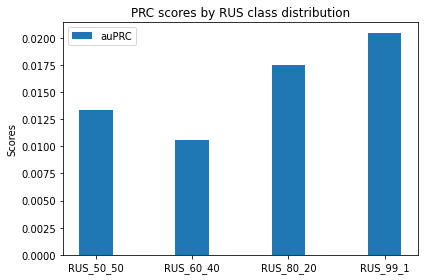

In [30]:
import matplotlib.pyplot as plt
import numpy as np


labels = results.keys()
auPRC_vals = [scores[0] for scores in results.values()]
auROC_vals = [scores[1] for scores in results.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
#rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PRC scores by RUS class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

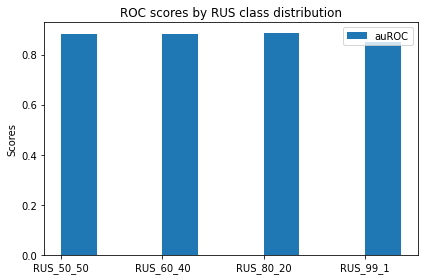

In [31]:
fig, ax = plt.subplots()
#rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ROC scores by RUS class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()